This Notebook is a library of functions for numerics of the incoherence simulations.

In [58]:
using BSON: @load
using Flux
using Flux: params
using Flux.Optimise
using Flux.Optimise: update!
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Zygote
using FFTW
using Distributions
using SparseArrays
using JLD

In [78]:
"""
    optimise(init_z, loss, opt, tolerance, [out_toggle = 0,][max_iter = 1_000_000])

    Optimization that stops when the gradient is small enough
"""
function optimise(opt, z, loss; tolerance, out_toggle, max_iter = 500_000)
    tol2 = tolerance^2
    ps = params(z)
    iter=1
    while true
        if iter > max_iter
            @warn "Max num. iterations reached"
            return nothing
        end
        grads = gradient(loss, ps) #loss cannot have any arguments
        update!(opt, ps, grads)
        succ_error = sum(abs2, grads[z])
        if out_toggle != 0 && iter % out_toggle == 0
            println("====> In Gradient: Iteration: $iter grad_size: $(sqrt(succ_error)) tolerance: $tolerance  error: ", string(sqrt(loss())))
        end
        if succ_error < tol2
            break
        end
        iter += 1
    end
    return z
end

optimise

In [79]:
evaluate_recovery(model, )

UndefVarError: UndefVarError: evaluate_recovery not defined

In [61]:
z = randn(10)
measurements = randn(12)
W = randn(12,10)
model(vec) = W*vec
loss(params_vec) = sum(abs2, measurements - model(params_vec))
opt = Descent()
optimise(opt, z, () -> loss(z), tolerance=1e-4)

UndefKeywordError: UndefKeywordError: keyword argument out_toggle not assigned

In [62]:
opt = Optimise.Descent(0.001) 
z = randn(10)
measurements = randn(12)
W = randn(12,10)
model(vec) = W*vec
ps = params(z)
loss(params_vec) = sum(abs2, measurements - model(vec))
tolerance = 1e-4
out_toggle = 0
max_iter = 500_000
tol2 = tolerance^2
iter=1
grads = gradient(() -> loss(ps), ps)
# while succ_error > tol2 
#         if iter > max_iter
#             @warn "Max num. iterations reached"
#             return nothing
#         end
#         grads = gradient(() -> loss(ps), ps)
#         update!(opt, ps, grads)
#         succ_error = sum(abs2, grads[z])
#         if out_toggle != 0 && iter % out_toggle == 0
#             println("====> In Gradient: Iteration: $iter grad_size: $(sqrt(succ_error)) tolerance: $tolerance  Loss: ", string(loss(z)))
#         end
#         iter += 1
#     end


MethodError: MethodError: no method matching *(::Matrix{Float64}, ::typeof(vec))
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:560
  *(::StridedMatrix{T}, !Matched::StridedVector{S}) where {T<:Union{Float32, Float64, ComplexF32, ComplexF64}, S<:Real} at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/matmul.jl:44
  *(::StridedMatrix{var"#s814"} where var"#s814"<:Union{Float32, Float64}, !Matched::StridedMatrix{var"#s813"} where var"#s813"<:Union{Float32, Float64, ComplexF32, ComplexF64}) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/matmul.jl:158
  ...

In [64]:
function sample_fourier(aimed_m, n)
    F = dct(diagm(ones(n)),2)
    sampling = rand(Bernoulli(aimed_m/n), n)
    true_m = sum(sampling)
    return (true_m, F[sampling,:]* sqrt(n/true_m)) # normalize it
end
function fourier(dim)
    dct(diagm(ones(dim)),2)
end

fourier (generic function with 1 method)

In [68]:
function subspace_incoherence(F, A)
    α = 0
    m, _ = size(A)
    QR_decomp = qr(A)
    for i in 1:m
        temp = norm(Matrix(QR_decomp.Q)'*F[i,:], 2)
        α = max(α, temp)
    end
    return α
end

subspace_incoherence (generic function with 1 method)

In [74]:
function recover_signal(measurements, measure, model, code_dim)
    function loss(signal_guess)
        return sum(abs2, measure(signal_guess) - measurements)
    end
    
    opt_code = optimise( Flux.Optimise.Descent(4e-5), loss, init=randn(code_dim)/sqrt(code_dim), tolerance=1e-6, out_toggle=20000)
    
    return opt_code != nothing ? model(opt_code) : nothing
end

recover_signal (generic function with 1 method)

In [75]:
β=0.5
k=32
mid = 64
n = 128
desired_m = 64
F = fourier(n)
k̂ = randn(k)/sqrt(k)
ps = Flux.params(k̂)
m, A = sample_fourier(desired_m, n)
model = Chain(
        Dense(k, mid, relu, bias = false; init =(out,in) -> randn(out,in)/sqrt(out)),
        Dense(mid, n, bias = false; init =(out,in) -> β*randn(out,in)/sqrt(out) + (1-β) * F[:,1:in])
    )
W₁ = Flux.params(model)[1]
W₂ = Flux.params(model)[2]
x₀ = model(randn(k)/sqrt(k))
modele() = model(k̂)
y= A*x₀
function loss()
    return sum(abs2, A*model(k̂) - y)
end

opt = Flux.Optimise.Descent(0.001)
out_log = 500_000
num_data = 5
tolerance = 4e-4
tol2 = tolerance^2
results = [[],[]]
max_iter = 500_000

for β in 0:0.1:1
    for i in 1:num_data
        W₁ .= randn(mid,k)
        W₂ .= β*randn(n,mid)/sqrt(n) + (1-β) * F[:,1:mid]
        i=1
        inco = matrix_alignment(W₂, F)
        
        optimise(opt,)
        
        while true
            i+=1
            gs = gradient( ps) do
                sum(abs2, A*model(k̂) - y)
            end
            update!(opt, ps,gs)
            if sum(abs2, gs[k̂]) < tol2
               push!(results[1], inco)
                push!(results[2], norm(model(k̂) - x₀))
                println("pushed result, error $(norm(model(k̂) - x₀)), incoherence $inco")
                break
            end
            if i > max_iter
                println("skipping train")
                break
            end
            i % out_log != 0 || @debug "loss: $(loss()), grad: $(sum(abs2, gs[k̂])), error: $(norm(model(k̂) - x₀))"
        end
    end
end
@debug "norm error is $(norm(model(k̂) - x₀))"

ErrorException: invalid redefinition of constant model

In [76]:
scatter(results[1], results[2])

UndefVarError: UndefVarError: results not defined

In [61]:
β=0.5
k=32
mid = 64
n = 128
desired_m = 80
F = fourier(n)
k̂ = randn(k)/sqrt(k)
ps = Flux.params(k̂)
m, A = sample_fourier(desired_m, n)
model = Chain(
        Dense(k, mid, relu, bias = false; init =(out,in) -> randn(out,in)/sqrt(out)),
        Dense(mid, n, bias = false; init =(out,in) -> β*randn(out,in)/sqrt(out) + (1-β) * F[:,1:in])
    )
W₁ = Flux.params(model)[1]
W₂ = Flux.params(model)[2]
x₀ = model(randn(k)/sqrt(k))
modele() = model(k̂)
y= A*x₀
function loss()
    return sum(abs2, A*model(k̂) - y)
end

opt = Flux.Optimise.Descent(0.001)
out_log = 10000
num_data = 5
tolerance = 4e-6
tol2 = tolerance^2
results = [[],[]]
max_iter = 500_000

W₁ .= randn(mid,k)
W₂ .= β*randn(n,mid)/sqrt(n) + (1-β) * F[:,1:mid]
i=1
inco = matrix_alignment(W₂, F)

opt

while true
         i+=1
    gs = gradient( ps) do
            sum(abs2, A*model(k̂) - y)
    end
    update!(opt, ps,gs)
    if sum(abs2, gs[k̂]) < tol2
    push!(results[1], inco)
                push!(results[2], norm(model(k̂) - x₀))
                println("pushed result, error $(norm(model(k̂) - x₀)), incoherence $inco")
                break
            end
            if i > max_iter
                println("skipping train")
                break
            end
            i % out_log != 0 || println("loss: $(loss()), grad: $(norm(gs[k̂])), error: $(norm(model(k̂) - x₀))")
  end

loss: 0.19069825800476656, grad: 0.0002665354924225208, error: 0.5091490975780901
loss: 0.19065269400739113, grad: 0.0002179459969456966, error: 0.509132001931581
loss: 0.1906776960242943, grad: 0.00043216373102096035, error: 0.509106659892179
loss: 0.19065514212367163, grad: 0.00027273163015454943, error: 0.5090657342665227
loss: 0.19064715100166038, grad: 0.00027177870967742324, error: 0.5090064923538545
loss: 0.19074739604526808, grad: 0.00045060363211546375, error: 0.5089552841353363
loss: 0.19076680528773282, grad: 0.0009055768067544585, error: 0.5095214371459466
loss: 0.190741615131089, grad: 0.0006476667813688257, error: 0.5095446436605321
loss: 0.19074620776924905, grad: 0.0001886521109714545, error: 0.508859281831471
loss: 0.19077676029999194, grad: 0.000742405748065938, error: 0.5095114801603651
loss: 0.19077375455694304, grad: 0.000802408974960393, error: 0.5094949139992587
loss: 0.19071531875466002, grad: 0.00024467275880756873, error: 0.5093783594269561
loss: 0.19069585241

LoadError: InterruptException:

In [39]:
results

2-element Vector{Vector{Any}}:
 [1.0000000000000002, 1.0000000000000002, 0.9942659371457384, 0.9959623561747436, 0.9931823810834856, 0.9941219735457206, 0.9717515916958956, 0.9838672395538788, 0.9777176600713909, 0.9810250064106377  …  0.7305789158590728, 0.7967836202406579, 0.7374595817063231, 0.7264824248248138, 0.7738522422224655, 0.7331029388714448, 0.7642969394195752, 0.7881124875129153, 0.746176168268236, 0.7431969021985918]
 [0.4238719166444773, 0.746121552148901, 0.591502828097277, 0.4924743355891634, 0.325576176750969, 0.4754218971988643, 0.576623921023499, 0.32062770712562, 0.32205242092702796, 0.6972299599272646  …  0.5000814495074147, 0.3319987524589201, 0.46951464437297336, 0.6889947057832015, 1.516733840323634, 0.5650658618180159, 0.3212102642971756, 0.5181258865207554, 0.4252844491763594, 0.6817183255728844]

In [ ]:
k=12
mid=15
n=50
aimed_m = 20

x₀ = model(randn(k)/sqrt(k))
m, A = sample_fourier(aimed_m, n)
y = A*x₀
println("signal norm: ", norm(x₀))
println("with measurements norm: ", norm(y))
x̂ = recover_signal(y, x -> A*x, model, k)
#println("recovered: ", x̂, " with measurements ", A*x̂)
println("norm of the error: ", norm(x̂ - x₀))
println("norm of recovered: ", norm(x̂))
#does not seem to work with gaussian.

In [ ]:
size(A)

In [112]:
function recovery_error(x₀, model, A, k)
    y = A*x₀
    x̂ = recover_signal(y, x -> A*x, model, k)
    if x̂ == nothing
        return nothing
    end
    return norm(x̂ - x₀)
end

recovery_error (generic function with 1 method)

In [122]:
k=15
mid=20
n=100
aimed_m = 35
plot_pairs = []
m, A = sample_fourier(aimed_m, n)
F = fourier(n)
W₁ = randn(mid, k)/sqrt(mid)
β=0.5
model = Chain(
        Dense(k, mid, relu, bias = false; init =(out,in) -> randn(out,in)/sqrt(out)),
        Dense(mid, n, I, bias = false; init =(out,in) -> β*randn(out,in)/sqrt(out) + (1-β) * F[:,1:in])
    )



Chain(
  Dense(15 => 20, relu; bias=false),    # 300 parameters
  Dense(20 => 100, UniformScaling{Bool}(true); bias=false),  # 2_000 parameters
) 

In [126]:
Flux.params(model)

Params([[0.00014177412729451383 -0.28278208239562747 … 0.34099851485182303 -0.11937219579573191; -0.3895810074855248 0.22259853425085346 … 0.25046148078423336 0.07928074480358631; … ; -0.16178405297115492 -0.498002227280967 … 0.4291426291479408 -0.2126396494000069; 0.11365651332188732 0.007388117940947938 … 0.249921189885099 0.3414077158704079], [-0.03150998455764323 0.12806804870264005 … -0.0615064100634827 0.04820680622814488; 0.012210641461380567 0.10458322117050275 … 0.04205990368966982 0.09076932418423025; … ; 0.02149001606284909 -0.07483381678307247 … 0.01875778611938514 -0.03781216199226888; 0.08176090346717065 -0.0170483677264531 … 0.0959891521421396 -0.08205273881889778]])

In [133]:
β_array = 0:0.5:1
num_trials = 2
k=15
mid=20
n=100
aimed_m = 35
plot_pairs = []
m, A = sample_fourier(aimed_m, n)
F = fourier(n)
W₁ = randn(mid, k)/sqrt(mid)
model = Chain(
        Dense(k, mid, relu, bias = false; init =(out,in) -> W₁),
        Dense(mid, n, I, bias = false; init =(out,in) -> β*randn(out,in)/sqrt(out) + (1-β) * F[1:out,:])
    )

ps = Flux.params(model)


for alignment in β_array
    signal_errors = []
    for i in 1:num_trials
        x₀ = randn(n)/sqrt(n)
        push!(signal_errors, recovery_error(x₀, model, A, k))
    end
    push!(plot_pairs, (alignment, copy(signal_errors)))
end


LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(100), Base.OneTo(20)), b has dims (Base.OneTo(100), Base.OneTo(100)), mismatch at 2")

In [166]:
gs = gradient( ps) do
    sum(abs2, A*model(k̂) - y)
end

Grads(...)

16-element Vector{Float64}:
  0.30027702283359187
  0.2977076782005569
 -0.08949439964775133
  0.016656954688092633
 -0.08932800903729907
  0.004374925532441641
  0.11108238090805175
 -0.11955577437375853
  0.11398397851865089
  0.02836328637681522
  0.004936957659845073
  0.11228908125099814
  0.15181775914691267
 -0.11135247035411971
  0.06926501873263716
 -0.057461113802936406

In [55]:
function experiment_1()
    β_array = 0:0.05:1
    num_signals = 10
    k=8
    mid=16
    n= 32
    aimed_m = 16
    plot_pairs = []
    m, A = sample_fourier(aimed_m, n)
    for (model, alignment) in get_aligned_models(k, mid,n, β_array)
        signal_errors = []
        for i in 1:num_signals
            x₀ = randn(n)/sqrt(n)
            push!(signal_errors, recovery_error(x₀, model, A, k))
        end
        push!(plot_pairs, (alignment, copy(signal_errors)))
    end
    return plot_pairs
end

experiment_1 (generic function with 1 method)

In [56]:
plot_pairs = experiment_1()

====> In Gradient: Iteration: 20000 grad_size: 6.075129912135128e-6 tolerance: 1.0e-6  Loss: 0.3352366891108532
====> In Gradient: Iteration: 40000 grad_size: 4.591219172808774e-6 tolerance: 1.0e-6  Loss: 0.3211911492121287
====> In Gradient: Iteration: 60000 grad_size: 3.5846039620405412e-6 tolerance: 1.0e-6  Loss: 0.3129194875447798
====> In Gradient: Iteration: 80000 grad_size: 2.87835073070835e-6 tolerance: 1.0e-6  Loss: 0.30774193033634856
====> In Gradient: Iteration: 100000 grad_size: 1.036602740794211e-5 tolerance: 1.0e-6  Loss: 0.2868459518695289
====> In Gradient: Iteration: 120000 grad_size: 5.771265682304706e-6 tolerance: 1.0e-6  Loss: 0.25666556263683393
====> In Gradient: Iteration: 140000 grad_size: 4.824958743784297e-6 tolerance: 1.0e-6  Loss: 0.24032765325832933
====> In Gradient: Iteration: 160000 grad_size: 3.6522198271102506e-6 tolerance: 1.0e-6  Loss: 0.23150519410309278
====> In Gradient: Iteration: 180000 grad_size: 2.956022955376718e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 9.964779524508077e-6 tolerance: 1.0e-6  Loss: 0.6210842184076643
====> In Gradient: Iteration: 40000 grad_size: 6.390693870544772e-6 tolerance: 1.0e-6  Loss: 0.5911183978826376
====> In Gradient: Iteration: 60000 grad_size: 5.374237463630806e-6 tolerance: 1.0e-6  Loss: 0.576542094846838
====> In Gradient: Iteration: 80000 grad_size: 4.605433209529434e-6 tolerance: 1.0e-6  Loss: 0.5664111682978317
====> In Gradient: Iteration: 100000 grad_size: 4.141607456824979e-6 tolerance: 1.0e-6  Loss: 0.558389698012828
====> In Gradient: Iteration: 120000 grad_size: 3.828271027949752e-6 tolerance: 1.0e-6  Loss: 0.5515601001406009
====> In Gradient: Iteration: 140000 grad_size: 3.591712961734433e-6 tolerance: 1.0e-6  Loss: 0.5455260670484613
====> In Gradient: Iteration: 160000 grad_size: 3.397375244014204e-6 tolerance: 1.0e-6  Loss: 0.5400946125750755
====> In Gradient: Iteration: 180000 grad_size: 5.186277950575363e-6 tolerance: 1.0e-6  Loss: 0.535156

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 5.2378556789378025e-6 tolerance: 1.0e-6  Loss: 0.5575628554379288
====> In Gradient: Iteration: 40000 grad_size: 5.9552731496392484e-6 tolerance: 1.0e-6  Loss: 0.549858775605879
====> In Gradient: Iteration: 60000 grad_size: 2.8699359190951195e-6 tolerance: 1.0e-6  Loss: 0.5459717322188836
====> In Gradient: Iteration: 80000 grad_size: 2.333815603127386e-6 tolerance: 1.0e-6  Loss: 0.543749626182733
====> In Gradient: Iteration: 100000 grad_size: 2.2934911424778045e-6 tolerance: 1.0e-6  Loss: 0.5412015346440234
====> In Gradient: Iteration: 120000 grad_size: 2.563047917699613e-6 tolerance: 1.0e-6  Loss: 0.5377159253031735
====> In Gradient: Iteration: 140000 grad_size: 2.004338489732184e-6 tolerance: 1.0e-6  Loss: 0.5353865827917562
====> In Gradient: Iteration: 160000 grad_size: 1.3271363609182226e-6 tolerance: 1.0e-6  Loss: 0.534077424096226
====> In Gradient: Iteration: 180000 grad_size: 1.0445015564087991e-6 tolerance: 1.0e-6  Loss: 0.5

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2425430875835384e-5 tolerance: 1.0e-6  Loss: 0.6893287132148725
====> In Gradient: Iteration: 40000 grad_size: 6.532300656710712e-6 tolerance: 1.0e-6  Loss: 0.66586818467868
====> In Gradient: Iteration: 60000 grad_size: 5.802933890718659e-6 tolerance: 1.0e-6  Loss: 0.6531493221275703
====> In Gradient: Iteration: 80000 grad_size: 5.326002819712831e-6 tolerance: 1.0e-6  Loss: 0.6427933130283487
====> In Gradient: Iteration: 100000 grad_size: 1.5027307174576167e-5 tolerance: 1.0e-6  Loss: 0.6366405582528212
====> In Gradient: Iteration: 120000 grad_size: 1.6705690958167855e-5 tolerance: 1.0e-6  Loss: 0.6051940778592358
====> In Gradient: Iteration: 140000 grad_size: 1.0664696058646002e-5 tolerance: 1.0e-6  Loss: 0.5928396781105832
====> In Gradient: Iteration: 160000 grad_size: 1.0064432080679687e-5 tolerance: 1.0e-6  Loss: 0.5867630431665122
====> In Gradient: Iteration: 180000 grad_size: 8.923635783986538e-6 tolerance: 1.0e-6  Loss: 0.5

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.951259809166154e-6 tolerance: 1.0e-6  Loss: 0.5144069438935014
====> In Gradient: Iteration: 40000 grad_size: 3.5860198844277294e-6 tolerance: 1.0e-6  Loss: 0.5038175136408684
====> In Gradient: Iteration: 60000 grad_size: 6.7946576913146095e-6 tolerance: 1.0e-6  Loss: 0.4992759581971462
====> In Gradient: Iteration: 80000 grad_size: 4.211591308863786e-6 tolerance: 1.0e-6  Loss: 0.4914621334629818
====> In Gradient: Iteration: 100000 grad_size: 3.7122052209733096e-6 tolerance: 1.0e-6  Loss: 0.484002084557614
====> In Gradient: Iteration: 120000 grad_size: 3.3727376179649915e-6 tolerance: 1.0e-6  Loss: 0.4782606966142754
====> In Gradient: Iteration: 140000 grad_size: 3.1242629811106045e-6 tolerance: 1.0e-6  Loss: 0.47365496487429193
====> In Gradient: Iteration: 160000 grad_size: 2.936471701922495e-6 tolerance: 1.0e-6  Loss: 0.4698505977715374
====> In Gradient: Iteration: 180000 grad_size: 2.791599033642652e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.4568933916084341e-5 tolerance: 1.0e-6  Loss: 0.5427491810306385
====> In Gradient: Iteration: 40000 grad_size: 8.365750819776798e-6 tolerance: 1.0e-6  Loss: 0.47514011213612245
====> In Gradient: Iteration: 20000 grad_size: 9.178127948709198e-6 tolerance: 1.0e-6  Loss: 0.4503471639915937
====> In Gradient: Iteration: 40000 grad_size: 3.620612259362871e-6 tolerance: 1.0e-6  Loss: 0.439384689655321
====> In Gradient: Iteration: 60000 grad_size: 3.141559151643617e-6 tolerance: 1.0e-6  Loss: 0.4337278163733512
====> In Gradient: Iteration: 80000 grad_size: 5.079922994421464e-6 tolerance: 1.0e-6  Loss: 0.42844253985976244
====> In Gradient: Iteration: 100000 grad_size: 2.413168028980254e-6 tolerance: 1.0e-6  Loss: 0.42232660692093155
====> In Gradient: Iteration: 120000 grad_size: 1.6903047083049211e-6 tolerance: 1.0e-6  Loss: 0.4204937220253433
====> In Gradient: Iteration: 140000 grad_size: 1.516098930724917e-6 tolerance: 1.0e-6  Loss: 0.41

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.0897812234073063e-5 tolerance: 1.0e-6  Loss: 0.5151526096086841
====> In Gradient: Iteration: 40000 grad_size: 4.267297060245939e-6 tolerance: 1.0e-6  Loss: 0.4792287922875792
====> In Gradient: Iteration: 60000 grad_size: 2.4149441408754903e-6 tolerance: 1.0e-6  Loss: 0.4752561008513683
====> In Gradient: Iteration: 80000 grad_size: 2.2682291877955916e-6 tolerance: 1.0e-6  Loss: 0.474166861521064
====> In Gradient: Iteration: 100000 grad_size: 1.5914684057553353e-5 tolerance: 1.0e-6  Loss: 0.47377086963835957
====> In Gradient: Iteration: 120000 grad_size: 2.350446240885122e-6 tolerance: 1.0e-6  Loss: 0.4735139771136514
====> In Gradient: Iteration: 140000 grad_size: 1.949390852890803e-6 tolerance: 1.0e-6  Loss: 0.4733352763483806
====> In Gradient: Iteration: 160000 grad_size: 1.9081807726517405e-6 tolerance: 1.0e-6  Loss: 0.47320846785399207
====> In Gradient: Iteration: 180000 grad_size: 1.8776635445560118e-6 tolerance: 1.0e-6  Loss:

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2187485162100817e-5 tolerance: 1.0e-6  Loss: 0.670278295370058
====> In Gradient: Iteration: 40000 grad_size: 4.145808278143848e-6 tolerance: 1.0e-6  Loss: 0.6425158149379706
====> In Gradient: Iteration: 60000 grad_size: 2.0614044269206787e-6 tolerance: 1.0e-6  Loss: 0.638302509431972
====> In Gradient: Iteration: 80000 grad_size: 1.4757716748672445e-6 tolerance: 1.0e-6  Loss: 0.6367956579448831
====> In Gradient: Iteration: 100000 grad_size: 1.1375746673440542e-6 tolerance: 1.0e-6  Loss: 0.6359494725167347
====> In Gradient: Iteration: 20000 grad_size: 1.081830714336834e-5 tolerance: 1.0e-6  Loss: 0.5126870359445103
====> In Gradient: Iteration: 40000 grad_size: 8.853440654826845e-6 tolerance: 1.0e-6  Loss: 0.49609776100850383
====> In Gradient: Iteration: 60000 grad_size: 8.148262905416103e-6 tolerance: 1.0e-6  Loss: 0.4880368469248526
====> In Gradient: Iteration: 80000 grad_size: 1.2165135347801078e-5 tolerance: 1.0e-6  Loss: 0.4806

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 5.367558356463121e-6 tolerance: 1.0e-6  Loss: 0.42012480035521416
====> In Gradient: Iteration: 40000 grad_size: 4.107587092054387e-6 tolerance: 1.0e-6  Loss: 0.4094491166776419
====> In Gradient: Iteration: 60000 grad_size: 3.47319717068645e-6 tolerance: 1.0e-6  Loss: 0.40231400705083326
====> In Gradient: Iteration: 80000 grad_size: 3.0071610631479475e-6 tolerance: 1.0e-6  Loss: 0.39709253872332245
====> In Gradient: Iteration: 100000 grad_size: 2.6553151214720632e-6 tolerance: 1.0e-6  Loss: 0.3931015513296876
====> In Gradient: Iteration: 120000 grad_size: 2.3817427950379766e-6 tolerance: 1.0e-6  Loss: 0.3899404733032166
====> In Gradient: Iteration: 140000 grad_size: 2.1623108236810636e-6 tolerance: 1.0e-6  Loss: 0.38736594227699994
====> In Gradient: Iteration: 160000 grad_size: 1.981130387917996e-6 tolerance: 1.0e-6  Loss: 0.3852241442169397
====> In Gradient: Iteration: 180000 grad_size: 1.8278525158534002e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 6.446296403775231e-6 tolerance: 1.0e-6  Loss: 0.4948256858320469
====> In Gradient: Iteration: 20000 grad_size: 2.16275900201126e-5 tolerance: 1.0e-6  Loss: 0.7053913247050784
====> In Gradient: Iteration: 40000 grad_size: 1.5399905050341745e-5 tolerance: 1.0e-6  Loss: 0.46355635954735613
====> In Gradient: Iteration: 60000 grad_size: 9.870630038316229e-6 tolerance: 1.0e-6  Loss: 0.3927259436263656
====> In Gradient: Iteration: 80000 grad_size: 5.7957538507849e-6 tolerance: 1.0e-6  Loss: 0.3701675248858373
====> In Gradient: Iteration: 100000 grad_size: 4.417516828612417e-6 tolerance: 1.0e-6  Loss: 0.3570296263438191
====> In Gradient: Iteration: 120000 grad_size: 3.831537658003643e-6 tolerance: 1.0e-6  Loss: 0.34917112572120995
====> In Gradient: Iteration: 140000 grad_size: 3.3748704946670596e-6 tolerance: 1.0e-6  Loss: 0.3431428023152054
====> In Gradient: Iteration: 160000 grad_size: 3.000767618983893e-6 tolerance: 1.0e-6  Loss: 0.3384

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2516497130050589e-5 tolerance: 1.0e-6  Loss: 0.5747520804848605
====> In Gradient: Iteration: 40000 grad_size: 8.088584879534434e-6 tolerance: 1.0e-6  Loss: 0.5247316595772068
====> In Gradient: Iteration: 60000 grad_size: 5.894663656438862e-6 tolerance: 1.0e-6  Loss: 0.5009089518485522
====> In Gradient: Iteration: 80000 grad_size: 4.586915236710305e-6 tolerance: 1.0e-6  Loss: 0.48737279607435396
====> In Gradient: Iteration: 100000 grad_size: 3.8145322518720177e-6 tolerance: 1.0e-6  Loss: 0.47918309375414675
====> In Gradient: Iteration: 120000 grad_size: 3.5614426661222856e-6 tolerance: 1.0e-6  Loss: 0.47439642687298267
====> In Gradient: Iteration: 140000 grad_size: 3.607922580909155e-6 tolerance: 1.0e-6  Loss: 0.4715861568838593
====> In Gradient: Iteration: 160000 grad_size: 3.977281007685879e-6 tolerance: 1.0e-6  Loss: 0.4698795365202885
====> In Gradient: Iteration: 180000 grad_size: 2.872197130310228e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.6047014940163345e-5 tolerance: 1.0e-6  Loss: 0.3701446121915954
====> In Gradient: Iteration: 40000 grad_size: 9.872146300246895e-6 tolerance: 1.0e-6  Loss: 0.290492214917594
====> In Gradient: Iteration: 60000 grad_size: 6.872346172407612e-6 tolerance: 1.0e-6  Loss: 0.25596868226091163
====> In Gradient: Iteration: 80000 grad_size: 6.49054488032565e-6 tolerance: 1.0e-6  Loss: 0.23751087945632188
====> In Gradient: Iteration: 100000 grad_size: 6.077887643024499e-6 tolerance: 1.0e-6  Loss: 0.22339899534837024
====> In Gradient: Iteration: 120000 grad_size: 3.850066039397345e-6 tolerance: 1.0e-6  Loss: 0.21139470761131512
====> In Gradient: Iteration: 140000 grad_size: 3.2548276060625243e-6 tolerance: 1.0e-6  Loss: 0.20642581538651703
====> In Gradient: Iteration: 160000 grad_size: 1.868127597993702e-6 tolerance: 1.0e-6  Loss: 0.20411585877863764
====> In Gradient: Iteration: 180000 grad_size: 1.7971192445611875e-6 tolerance: 1.0e-6  Loss:

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.9276403493615994e-5 tolerance: 1.0e-6  Loss: 0.8179830102062194
====> In Gradient: Iteration: 40000 grad_size: 1.2731188986822476e-5 tolerance: 1.0e-6  Loss: 0.6944290990608798
====> In Gradient: Iteration: 60000 grad_size: 7.31876903348765e-6 tolerance: 1.0e-6  Loss: 0.649374150462933
====> In Gradient: Iteration: 80000 grad_size: 2.2636817935853183e-6 tolerance: 1.0e-6  Loss: 0.6414708215424669
====> In Gradient: Iteration: 100000 grad_size: 6.2819832436794505e-6 tolerance: 1.0e-6  Loss: 0.6392114339120174
====> In Gradient: Iteration: 120000 grad_size: 1.8996916638584507e-6 tolerance: 1.0e-6  Loss: 0.6373168531997085
====> In Gradient: Iteration: 140000 grad_size: 1.7967364606531715e-6 tolerance: 1.0e-6  Loss: 0.6356466504192937
====> In Gradient: Iteration: 160000 grad_size: 1.7041444807184359e-6 tolerance: 1.0e-6  Loss: 0.6341527133139252
====> In Gradient: Iteration: 180000 grad_size: 1.6172797393932548e-6 tolerance: 1.0e-6  Loss: 

====> In Gradient: Iteration: 460000 grad_size: 2.074512154936995e-6 tolerance: 1.0e-6  Loss: 0.5656014281983262
====> In Gradient: Iteration: 480000 grad_size: 2.0718410641866336e-6 tolerance: 1.0e-6  Loss: 0.5650268000140409
====> In Gradient: Iteration: 500000 grad_size: 2.567946309989966e-6 tolerance: 1.0e-6  Loss: 0.5644822932097309


┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.6680585394092385e-5 tolerance: 1.0e-6  Loss: 0.5821771913109572
====> In Gradient: Iteration: 40000 grad_size: 7.6063994947901375e-6 tolerance: 1.0e-6  Loss: 0.5328979054027699
====> In Gradient: Iteration: 60000 grad_size: 6.4839188011421175e-6 tolerance: 1.0e-6  Loss: 0.5090535469589251
====> In Gradient: Iteration: 80000 grad_size: 6.56461714298066e-6 tolerance: 1.0e-6  Loss: 0.5006218079260658
====> In Gradient: Iteration: 100000 grad_size: 2.9979746459867487e-6 tolerance: 1.0e-6  Loss: 0.4980893700885359
====> In Gradient: Iteration: 120000 grad_size: 5.3825500755105595e-6 tolerance: 1.0e-6  Loss: 0.4961957884567836
====> In Gradient: Iteration: 140000 grad_size: 2.812719232802714e-6 tolerance: 1.0e-6  Loss: 0.49455932365986616
====> In Gradient: Iteration: 160000 grad_size: 5.323454085631787e-6 tolerance: 1.0e-6  Loss: 0.4931090875263358
====> In Gradient: Iteration: 180000 grad_size: 5.295931904981865e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2165022061646788e-5 tolerance: 1.0e-6  Loss: 0.5922826729770433
====> In Gradient: Iteration: 40000 grad_size: 5.806945910833114e-6 tolerance: 1.0e-6  Loss: 0.5682085632433377
====> In Gradient: Iteration: 60000 grad_size: 3.693478493244514e-6 tolerance: 1.0e-6  Loss: 0.5570632219806517
====> In Gradient: Iteration: 80000 grad_size: 3.1864673629079773e-6 tolerance: 1.0e-6  Loss: 0.5514569786984347
====> In Gradient: Iteration: 100000 grad_size: 2.801209274958535e-6 tolerance: 1.0e-6  Loss: 0.5471452318617487
====> In Gradient: Iteration: 120000 grad_size: 2.500797133153383e-6 tolerance: 1.0e-6  Loss: 0.5437291807349688
====> In Gradient: Iteration: 140000 grad_size: 2.2756510401208093e-6 tolerance: 1.0e-6  Loss: 0.5411010472128432
====> In Gradient: Iteration: 160000 grad_size: 1.5024631716064624e-6 tolerance: 1.0e-6  Loss: 0.5398250995301356
====> In Gradient: Iteration: 180000 grad_size: 1.2839899480184978e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 4.843237262597314e-6 tolerance: 1.0e-6  Loss: 0.5422765940585509
====> In Gradient: Iteration: 40000 grad_size: 7.339796536007926e-6 tolerance: 1.0e-6  Loss: 0.527487243183098
====> In Gradient: Iteration: 60000 grad_size: 1.0541410111741213e-5 tolerance: 1.0e-6  Loss: 0.5105103024200196
====> In Gradient: Iteration: 80000 grad_size: 4.840686332046105e-6 tolerance: 1.0e-6  Loss: 0.49881783940483315
====> In Gradient: Iteration: 100000 grad_size: 4.852184764576671e-6 tolerance: 1.0e-6  Loss: 0.4906439198751917
====> In Gradient: Iteration: 120000 grad_size: 3.9255961393228125e-6 tolerance: 1.0e-6  Loss: 0.485071365841206
====> In Gradient: Iteration: 140000 grad_size: 3.678386362237878e-6 tolerance: 1.0e-6  Loss: 0.4806121338905205
====> In Gradient: Iteration: 160000 grad_size: 3.8018740938994295e-6 tolerance: 1.0e-6  Loss: 0.4782018273980535
====> In Gradient: Iteration: 180000 grad_size: 3.168189439568603e-6 tolerance: 1.0e-6  Loss: 0.47

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.768507291669441e-6 tolerance: 1.0e-6  Loss: 0.21291413939752668
====> In Gradient: Iteration: 40000 grad_size: 4.948816528118805e-6 tolerance: 1.0e-6  Loss: 0.19151571438278675
====> In Gradient: Iteration: 60000 grad_size: 3.8312848914702655e-6 tolerance: 1.0e-6  Loss: 0.18223558696043923
====> In Gradient: Iteration: 80000 grad_size: 3.309841795933219e-6 tolerance: 1.0e-6  Loss: 0.175926359217361
====> In Gradient: Iteration: 100000 grad_size: 2.2318520977649927e-6 tolerance: 1.0e-6  Loss: 0.1713205816430684
====> In Gradient: Iteration: 120000 grad_size: 1.891550763796033e-6 tolerance: 1.0e-6  Loss: 0.16921121708490555
====> In Gradient: Iteration: 140000 grad_size: 5.4545063416045825e-6 tolerance: 1.0e-6  Loss: 0.1404392656872036
====> In Gradient: Iteration: 160000 grad_size: 3.426367232910834e-6 tolerance: 1.0e-6  Loss: 0.1314971990432262
====> In Gradient: Iteration: 180000 grad_size: 2.7227601378132496e-6 tolerance: 1.0e-6  Loss:

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 7.792611800978633e-6 tolerance: 1.0e-6  Loss: 1.1172405986595755
====> In Gradient: Iteration: 40000 grad_size: 5.73412204049407e-6 tolerance: 1.0e-6  Loss: 1.0961808796066006
====> In Gradient: Iteration: 60000 grad_size: 5.414750153302625e-6 tolerance: 1.0e-6  Loss: 1.0806604494202052
====> In Gradient: Iteration: 80000 grad_size: 5.132097176218092e-6 tolerance: 1.0e-6  Loss: 1.0667657164715836
====> In Gradient: Iteration: 100000 grad_size: 4.874629167850031e-6 tolerance: 1.0e-6  Loss: 1.0542550898865104
====> In Gradient: Iteration: 120000 grad_size: 4.636046887269731e-6 tolerance: 1.0e-6  Loss: 1.042952778784763
====> In Gradient: Iteration: 140000 grad_size: 4.412775810832809e-6 tolerance: 1.0e-6  Loss: 1.0327208881092849
====> In Gradient: Iteration: 160000 grad_size: 4.2026583764857575e-6 tolerance: 1.0e-6  Loss: 1.023445302512242
====> In Gradient: Iteration: 180000 grad_size: 1.4223833712623961e-5 tolerance: 1.0e-6  Loss: 1.01533

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.0825228282062494e-5 tolerance: 1.0e-6  Loss: 0.5824995211169977
====> In Gradient: Iteration: 40000 grad_size: 1.0187810419226426e-5 tolerance: 1.0e-6  Loss: 0.5428360441282729
====> In Gradient: Iteration: 60000 grad_size: 7.769235525936632e-6 tolerance: 1.0e-6  Loss: 0.5238835910610619
====> In Gradient: Iteration: 80000 grad_size: 6.777116900565572e-6 tolerance: 1.0e-6  Loss: 0.5133983751512827
====> In Gradient: Iteration: 100000 grad_size: 1.1970213012810032e-5 tolerance: 1.0e-6  Loss: 0.4940202011562252
====> In Gradient: Iteration: 120000 grad_size: 8.683406540702745e-6 tolerance: 1.0e-6  Loss: 0.4531300494843998
====> In Gradient: Iteration: 140000 grad_size: 7.628516886820854e-6 tolerance: 1.0e-6  Loss: 0.429225380394037
====> In Gradient: Iteration: 160000 grad_size: 6.440874091645644e-6 tolerance: 1.0e-6  Loss: 0.41658889356090667
====> In Gradient: Iteration: 180000 grad_size: 5.5696354071558365e-6 tolerance: 1.0e-6  Loss: 0.

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.3327491049550771e-5 tolerance: 1.0e-6  Loss: 0.49110167612189204
====> In Gradient: Iteration: 40000 grad_size: 9.527235394863816e-6 tolerance: 1.0e-6  Loss: 0.4344504269227712
====> In Gradient: Iteration: 60000 grad_size: 8.081780850287563e-6 tolerance: 1.0e-6  Loss: 0.39593169624915264
====> In Gradient: Iteration: 80000 grad_size: 7.380981592678865e-6 tolerance: 1.0e-6  Loss: 0.3665626805159128
====> In Gradient: Iteration: 100000 grad_size: 5.7941617530211275e-6 tolerance: 1.0e-6  Loss: 0.34544254824893933
====> In Gradient: Iteration: 120000 grad_size: 4.1417300458925094e-6 tolerance: 1.0e-6  Loss: 0.33467852593148784
====> In Gradient: Iteration: 140000 grad_size: 1.4685451002348652e-6 tolerance: 1.0e-6  Loss: 0.3275944602078083
====> In Gradient: Iteration: 20000 grad_size: 9.177119875015722e-6 tolerance: 1.0e-6  Loss: 0.47621706036868267
====> In Gradient: Iteration: 40000 grad_size: 6.6516637370689775e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.736875200223887e-6 tolerance: 1.0e-6  Loss: 0.4752373440404529
====> In Gradient: Iteration: 40000 grad_size: 6.848808419298821e-6 tolerance: 1.0e-6  Loss: 0.445630515800382
====> In Gradient: Iteration: 60000 grad_size: 6.135797018100929e-6 tolerance: 1.0e-6  Loss: 0.4295414289338428
====> In Gradient: Iteration: 80000 grad_size: 5.657167412344421e-6 tolerance: 1.0e-6  Loss: 0.4173502947106613
====> In Gradient: Iteration: 100000 grad_size: 8.99279767470128e-6 tolerance: 1.0e-6  Loss: 0.4074208665402764
====> In Gradient: Iteration: 120000 grad_size: 8.98271829083037e-6 tolerance: 1.0e-6  Loss: 0.39952954017971803
====> In Gradient: Iteration: 140000 grad_size: 8.987350818255448e-6 tolerance: 1.0e-6  Loss: 0.39280557081448486
====> In Gradient: Iteration: 160000 grad_size: 4.669303139161803e-6 tolerance: 1.0e-6  Loss: 0.3868407662743887
====> In Gradient: Iteration: 180000 grad_size: 4.425597244774701e-6 tolerance: 1.0e-6  Loss: 0.38184

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 2.0407557227121964e-5 tolerance: 1.0e-6  Loss: 0.2910325158175249
====> In Gradient: Iteration: 40000 grad_size: 6.119538484403644e-6 tolerance: 1.0e-6  Loss: 0.2180179992876074
====> In Gradient: Iteration: 60000 grad_size: 3.976436621016228e-6 tolerance: 1.0e-6  Loss: 0.20623819981163727
====> In Gradient: Iteration: 80000 grad_size: 2.8861563475932133e-6 tolerance: 1.0e-6  Loss: 0.20044084615706986
====> In Gradient: Iteration: 100000 grad_size: 2.547169703583963e-6 tolerance: 1.0e-6  Loss: 0.19678249276062762
====> In Gradient: Iteration: 120000 grad_size: 2.303996162423321e-6 tolerance: 1.0e-6  Loss: 0.19386039153564363
====> In Gradient: Iteration: 140000 grad_size: 2.1232628676238065e-6 tolerance: 1.0e-6  Loss: 0.1914271316208254
====> In Gradient: Iteration: 160000 grad_size: 1.9859240095419805e-6 tolerance: 1.0e-6  Loss: 0.18933538489875015
====> In Gradient: Iteration: 180000 grad_size: 1.24462320285603e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2995872842282369e-5 tolerance: 1.0e-6  Loss: 0.2737490334066715
====> In Gradient: Iteration: 40000 grad_size: 4.6295251305248045e-6 tolerance: 1.0e-6  Loss: 0.24532301365775333
====> In Gradient: Iteration: 60000 grad_size: 5.084802812394123e-6 tolerance: 1.0e-6  Loss: 0.2363197992103876
====> In Gradient: Iteration: 80000 grad_size: 5.062648184126111e-6 tolerance: 1.0e-6  Loss: 0.22955015837432133
====> In Gradient: Iteration: 100000 grad_size: 3.18605377105378e-6 tolerance: 1.0e-6  Loss: 0.22439577620106343
====> In Gradient: Iteration: 120000 grad_size: 4.086490567921769e-6 tolerance: 1.0e-6  Loss: 0.22001766839694065
====> In Gradient: Iteration: 140000 grad_size: 3.6824456788394664e-6 tolerance: 1.0e-6  Loss: 0.21626523477905307
====> In Gradient: Iteration: 160000 grad_size: 3.318931569080456e-6 tolerance: 1.0e-6  Loss: 0.21303519104357907
====> In Gradient: Iteration: 180000 grad_size: 2.4950745871123825e-6 tolerance: 1.0e-6  Los

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.3615893044471085e-5 tolerance: 1.0e-6  Loss: 0.48784346554277025
====> In Gradient: Iteration: 40000 grad_size: 5.977879537875858e-6 tolerance: 1.0e-6  Loss: 0.4319525556744813
====> In Gradient: Iteration: 60000 grad_size: 5.176316489082146e-6 tolerance: 1.0e-6  Loss: 0.41767709936332303
====> In Gradient: Iteration: 80000 grad_size: 5.266299911450154e-6 tolerance: 1.0e-6  Loss: 0.40927377572700385
====> In Gradient: Iteration: 100000 grad_size: 3.986934939445882e-6 tolerance: 1.0e-6  Loss: 0.40336591330036103
====> In Gradient: Iteration: 120000 grad_size: 3.817173637066013e-6 tolerance: 1.0e-6  Loss: 0.3991705239502873
====> In Gradient: Iteration: 140000 grad_size: 6.343282520555608e-6 tolerance: 1.0e-6  Loss: 0.39554306844581716
====> In Gradient: Iteration: 160000 grad_size: 3.4582258064546034e-6 tolerance: 1.0e-6  Loss: 0.39237213539883387
====> In Gradient: Iteration: 180000 grad_size: 3.276317084413212e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.336835850869827e-6 tolerance: 1.0e-6  Loss: 0.3570153850733643
====> In Gradient: Iteration: 40000 grad_size: 5.745141082291368e-6 tolerance: 1.0e-6  Loss: 0.3338401492289202
====> In Gradient: Iteration: 60000 grad_size: 4.899863859076377e-6 tolerance: 1.0e-6  Loss: 0.31996057125685606
====> In Gradient: Iteration: 80000 grad_size: 4.4414641166599086e-6 tolerance: 1.0e-6  Loss: 0.3091116098300591
====> In Gradient: Iteration: 100000 grad_size: 4.090012133850384e-6 tolerance: 1.0e-6  Loss: 0.30003056607715434
====> In Gradient: Iteration: 120000 grad_size: 3.7864204375670748e-6 tolerance: 1.0e-6  Loss: 0.2922842620485215
====> In Gradient: Iteration: 140000 grad_size: 3.515810434849001e-6 tolerance: 1.0e-6  Loss: 0.2856249118995412
====> In Gradient: Iteration: 160000 grad_size: 3.272674926294176e-6 tolerance: 1.0e-6  Loss: 0.2798692900077474
====> In Gradient: Iteration: 180000 grad_size: 3.053733635781083e-6 tolerance: 1.0e-6  Loss: 0.

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.9817349121974094e-5 tolerance: 1.0e-6  Loss: 0.6165715571414656
====> In Gradient: Iteration: 40000 grad_size: 7.63634409765353e-6 tolerance: 1.0e-6  Loss: 0.5079655648127718
====> In Gradient: Iteration: 60000 grad_size: 3.1976012844039086e-6 tolerance: 1.0e-6  Loss: 0.4963802577853532
====> In Gradient: Iteration: 80000 grad_size: 2.7941900585770315e-6 tolerance: 1.0e-6  Loss: 0.49394032620751654
====> In Gradient: Iteration: 100000 grad_size: 4.481316547089494e-6 tolerance: 1.0e-6  Loss: 0.49258193891452356
====> In Gradient: Iteration: 120000 grad_size: 4.477780805630112e-6 tolerance: 1.0e-6  Loss: 0.4915728134970825
====> In Gradient: Iteration: 140000 grad_size: 4.267663705485025e-6 tolerance: 1.0e-6  Loss: 0.49074793634889613
====> In Gradient: Iteration: 160000 grad_size: 4.348310615137491e-6 tolerance: 1.0e-6  Loss: 0.4900391211868602
====> In Gradient: Iteration: 180000 grad_size: 4.1196016872186795e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 2.3667841633231026e-5 tolerance: 1.0e-6  Loss: 0.7167602466436362
====> In Gradient: Iteration: 40000 grad_size: 1.809980797127246e-5 tolerance: 1.0e-6  Loss: 0.5563328658059021
====> In Gradient: Iteration: 60000 grad_size: 8.944388424502702e-6 tolerance: 1.0e-6  Loss: 0.4704006142904294
====> In Gradient: Iteration: 80000 grad_size: 5.881011599139052e-6 tolerance: 1.0e-6  Loss: 0.4443307179571938
====> In Gradient: Iteration: 100000 grad_size: 5.474971498022922e-6 tolerance: 1.0e-6  Loss: 0.4302553138295673
====> In Gradient: Iteration: 120000 grad_size: 4.775048506928355e-6 tolerance: 1.0e-6  Loss: 0.41835447833764416
====> In Gradient: Iteration: 140000 grad_size: 4.35857346750683e-6 tolerance: 1.0e-6  Loss: 0.40908467112454844
====> In Gradient: Iteration: 160000 grad_size: 9.30892039386311e-6 tolerance: 1.0e-6  Loss: 0.36994025317996676
====> In Gradient: Iteration: 180000 grad_size: 4.4091351695712355e-6 tolerance: 1.0e-6  Loss: 0.3

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.480451460357993e-6 tolerance: 1.0e-6  Loss: 0.5854979176616558
====> In Gradient: Iteration: 40000 grad_size: 6.1721830340701394e-6 tolerance: 1.0e-6  Loss: 0.560228642542558
====> In Gradient: Iteration: 60000 grad_size: 8.307564938833263e-6 tolerance: 1.0e-6  Loss: 0.5414125021549601
====> In Gradient: Iteration: 80000 grad_size: 6.031207862543668e-6 tolerance: 1.0e-6  Loss: 0.5152081129756673
====> In Gradient: Iteration: 100000 grad_size: 5.238048814417765e-6 tolerance: 1.0e-6  Loss: 0.5005913776957789
====> In Gradient: Iteration: 120000 grad_size: 4.694968805373756e-6 tolerance: 1.0e-6  Loss: 0.48912013616210925
====> In Gradient: Iteration: 140000 grad_size: 5.3460457969956625e-6 tolerance: 1.0e-6  Loss: 0.47977334164622115
====> In Gradient: Iteration: 160000 grad_size: 3.87835614916407e-6 tolerance: 1.0e-6  Loss: 0.47204169923346173
====> In Gradient: Iteration: 180000 grad_size: 3.5509691378069816e-6 tolerance: 1.0e-6  Loss: 0.

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.1090272680154586e-5 tolerance: 1.0e-6  Loss: 0.6927430671259435
====> In Gradient: Iteration: 40000 grad_size: 6.831173722421533e-6 tolerance: 1.0e-6  Loss: 0.6624964908339934
====> In Gradient: Iteration: 60000 grad_size: 6.2576991294996155e-6 tolerance: 1.0e-6  Loss: 0.641174730131286
====> In Gradient: Iteration: 80000 grad_size: 3.20108856309202e-6 tolerance: 1.0e-6  Loss: 0.634837076221103
====> In Gradient: Iteration: 100000 grad_size: 2.760987513080064e-6 tolerance: 1.0e-6  Loss: 0.6315098416253215
====> In Gradient: Iteration: 120000 grad_size: 2.2556972373282463e-6 tolerance: 1.0e-6  Loss: 0.6296529080100132
====> In Gradient: Iteration: 140000 grad_size: 2.8634375817353557e-6 tolerance: 1.0e-6  Loss: 0.6285710933567487
====> In Gradient: Iteration: 160000 grad_size: 1.9931216889056022e-6 tolerance: 1.0e-6  Loss: 0.6277715498659031
====> In Gradient: Iteration: 180000 grad_size: 2.6585514251438725e-6 tolerance: 1.0e-6  Loss: 0.6

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.0013197457871159e-5 tolerance: 1.0e-6  Loss: 0.49095540951519817
====> In Gradient: Iteration: 40000 grad_size: 6.729615708542717e-6 tolerance: 1.0e-6  Loss: 0.45787670570704186
====> In Gradient: Iteration: 60000 grad_size: 5.087463793192314e-6 tolerance: 1.0e-6  Loss: 0.44068814000734696
====> In Gradient: Iteration: 80000 grad_size: 5.978307625244709e-6 tolerance: 1.0e-6  Loss: 0.4295519256054497
====> In Gradient: Iteration: 100000 grad_size: 4.339246770457966e-6 tolerance: 1.0e-6  Loss: 0.4165644267579738
====> In Gradient: Iteration: 120000 grad_size: 3.3388606255855083e-6 tolerance: 1.0e-6  Loss: 0.4096030036417011
====> In Gradient: Iteration: 140000 grad_size: 1.1816741173803353e-5 tolerance: 1.0e-6  Loss: 0.3795520776699139
====> In Gradient: Iteration: 160000 grad_size: 6.2764744979297365e-6 tolerance: 1.0e-6  Loss: 0.34283431096721184
====> In Gradient: Iteration: 180000 grad_size: 3.925580524309902e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.1206021038003461e-5 tolerance: 1.0e-6  Loss: 0.5593789799218846
====> In Gradient: Iteration: 40000 grad_size: 7.161978262505845e-6 tolerance: 1.0e-6  Loss: 0.519259462232829
====> In Gradient: Iteration: 60000 grad_size: 5.85056466433751e-6 tolerance: 1.0e-6  Loss: 0.5032756971546305
====> In Gradient: Iteration: 80000 grad_size: 3.7033496131121205e-6 tolerance: 1.0e-6  Loss: 0.49490215215987604
====> In Gradient: Iteration: 100000 grad_size: 3.1472218331919817e-6 tolerance: 1.0e-6  Loss: 0.48918205937069703
====> In Gradient: Iteration: 120000 grad_size: 2.7496308919636654e-6 tolerance: 1.0e-6  Loss: 0.484946094709486
====> In Gradient: Iteration: 140000 grad_size: 2.439635365603837e-6 tolerance: 1.0e-6  Loss: 0.48166111547075524
====> In Gradient: Iteration: 160000 grad_size: 2.185367161335533e-6 tolerance: 1.0e-6  Loss: 0.47904396857702986
====> In Gradient: Iteration: 180000 grad_size: 1.9712379168182366e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.172236335421923e-6 tolerance: 1.0e-6  Loss: 0.7749036329138819
====> In Gradient: Iteration: 40000 grad_size: 9.53036461047883e-6 tolerance: 1.0e-6  Loss: 0.7440067299233635
====> In Gradient: Iteration: 60000 grad_size: 8.121216528652968e-6 tolerance: 1.0e-6  Loss: 0.7189709761474645
====> In Gradient: Iteration: 80000 grad_size: 8.085305782365179e-6 tolerance: 1.0e-6  Loss: 0.6939372335039133
====> In Gradient: Iteration: 100000 grad_size: 5.6983012342883065e-6 tolerance: 1.0e-6  Loss: 0.6778208371754012
====> In Gradient: Iteration: 120000 grad_size: 5.721305665528152e-6 tolerance: 1.0e-6  Loss: 0.6670321941147076
====> In Gradient: Iteration: 140000 grad_size: 4.9314122319144685e-6 tolerance: 1.0e-6  Loss: 0.6598849980776929
====> In Gradient: Iteration: 160000 grad_size: 4.623579442617216e-6 tolerance: 1.0e-6  Loss: 0.6551715942457935
====> In Gradient: Iteration: 180000 grad_size: 3.983048521179002e-6 tolerance: 1.0e-6  Loss: 0.651

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2466319514471344e-5 tolerance: 1.0e-6  Loss: 0.39473260278908734
====> In Gradient: Iteration: 40000 grad_size: 1.1802269243637534e-5 tolerance: 1.0e-6  Loss: 0.34834560965454087
====> In Gradient: Iteration: 60000 grad_size: 3.4245654451242056e-6 tolerance: 1.0e-6  Loss: 0.3367777498559796
====> In Gradient: Iteration: 80000 grad_size: 3.0394916688483345e-6 tolerance: 1.0e-6  Loss: 0.33476572664616994
====> In Gradient: Iteration: 100000 grad_size: 2.8218345135785866e-6 tolerance: 1.0e-6  Loss: 0.33328930498376025
====> In Gradient: Iteration: 120000 grad_size: 6.334674550890128e-6 tolerance: 1.0e-6  Loss: 0.3321903312548589
====> In Gradient: Iteration: 140000 grad_size: 2.512488026949241e-6 tolerance: 1.0e-6  Loss: 0.3313704631223812
====> In Gradient: Iteration: 160000 grad_size: 2.405099359145063e-6 tolerance: 1.0e-6  Loss: 0.33075939897051415
====> In Gradient: Iteration: 180000 grad_size: 2.321182292869936e-6 tolerance: 1.0e-6  Lo

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.0173789265067803e-5 tolerance: 1.0e-6  Loss: 0.48261927190871023
====> In Gradient: Iteration: 40000 grad_size: 7.273902062058976e-6 tolerance: 1.0e-6  Loss: 0.44556040413101394
====> In Gradient: Iteration: 60000 grad_size: 6.059285553306294e-6 tolerance: 1.0e-6  Loss: 0.4226208595955972
====> In Gradient: Iteration: 80000 grad_size: 5.615977092187146e-6 tolerance: 1.0e-6  Loss: 0.40501627897327336
====> In Gradient: Iteration: 100000 grad_size: 4.968381883656755e-6 tolerance: 1.0e-6  Loss: 0.3910698798976431
====> In Gradient: Iteration: 120000 grad_size: 4.460317953162227e-6 tolerance: 1.0e-6  Loss: 0.379991574245289
====> In Gradient: Iteration: 140000 grad_size: 3.8015031184693935e-6 tolerance: 1.0e-6  Loss: 0.37111659434447625
====> In Gradient: Iteration: 160000 grad_size: 3.560034313542454e-6 tolerance: 1.0e-6  Loss: 0.3647297535720958
====> In Gradient: Iteration: 180000 grad_size: 3.0304711814325408e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 2.1517990477338427e-5 tolerance: 1.0e-6  Loss: 0.8591282596264607
====> In Gradient: Iteration: 40000 grad_size: 1.1599212864783404e-5 tolerance: 1.0e-6  Loss: 0.7470966009016627
====> In Gradient: Iteration: 60000 grad_size: 4.302900064369176e-6 tolerance: 1.0e-6  Loss: 0.7192972972351399
====> In Gradient: Iteration: 80000 grad_size: 4.013163098791934e-6 tolerance: 1.0e-6  Loss: 0.7158403078750727
====> In Gradient: Iteration: 100000 grad_size: 3.857026096030813e-6 tolerance: 1.0e-6  Loss: 0.713317441936508
====> In Gradient: Iteration: 120000 grad_size: 2.433338637725666e-6 tolerance: 1.0e-6  Loss: 0.7111366088585072
====> In Gradient: Iteration: 140000 grad_size: 3.2249798776372383e-6 tolerance: 1.0e-6  Loss: 0.7092299380257345
====> In Gradient: Iteration: 160000 grad_size: 2.182419492292065e-6 tolerance: 1.0e-6  Loss: 0.7075462086328055
====> In Gradient: Iteration: 180000 grad_size: 2.0750017769670886e-6 tolerance: 1.0e-6  Loss: 0.7

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 7.3921953687219595e-6 tolerance: 1.0e-6  Loss: 0.566282485417951
====> In Gradient: Iteration: 40000 grad_size: 6.643783279089966e-6 tolerance: 1.0e-6  Loss: 0.5385227090697704
====> In Gradient: Iteration: 60000 grad_size: 6.9660613509747146e-6 tolerance: 1.0e-6  Loss: 0.5153858475469361
====> In Gradient: Iteration: 80000 grad_size: 6.115343981492936e-6 tolerance: 1.0e-6  Loss: 0.49411136278593837
====> In Gradient: Iteration: 100000 grad_size: 5.331849131215307e-6 tolerance: 1.0e-6  Loss: 0.47758562621055245
====> In Gradient: Iteration: 120000 grad_size: 3.798616430677383e-6 tolerance: 1.0e-6  Loss: 0.46945854114414887
====> In Gradient: Iteration: 140000 grad_size: 2.8184946390951984e-6 tolerance: 1.0e-6  Loss: 0.46484121660404987
====> In Gradient: Iteration: 160000 grad_size: 2.1813604589569265e-6 tolerance: 1.0e-6  Loss: 0.4619972721555327
====> In Gradient: Iteration: 180000 grad_size: 1.7632430881786557e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 9.022508871356563e-6 tolerance: 1.0e-6  Loss: 0.39029198738120846
====> In Gradient: Iteration: 40000 grad_size: 3.819865750622822e-6 tolerance: 1.0e-6  Loss: 0.37435269660805487
====> In Gradient: Iteration: 60000 grad_size: 2.8655269469234942e-6 tolerance: 1.0e-6  Loss: 0.3684322340020995
====> In Gradient: Iteration: 80000 grad_size: 2.439438833081511e-6 tolerance: 1.0e-6  Loss: 0.3655349061254809
====> In Gradient: Iteration: 100000 grad_size: 2.373960722395087e-6 tolerance: 1.0e-6  Loss: 0.3635139515401627
====> In Gradient: Iteration: 120000 grad_size: 2.1071173943037425e-6 tolerance: 1.0e-6  Loss: 0.36206498895401357
====> In Gradient: Iteration: 140000 grad_size: 1.6829525901536424e-6 tolerance: 1.0e-6  Loss: 0.36097891972540674
====> In Gradient: Iteration: 160000 grad_size: 3.3201292874242867e-6 tolerance: 1.0e-6  Loss: 0.3601421730438259
====> In Gradient: Iteration: 180000 grad_size: 1.3339076804658054e-6 tolerance: 1.0e-6  Los

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.4646319476119376e-5 tolerance: 1.0e-6  Loss: 0.5839420472942449
====> In Gradient: Iteration: 40000 grad_size: 6.730039971559172e-6 tolerance: 1.0e-6  Loss: 0.5276463372226121
====> In Gradient: Iteration: 60000 grad_size: 5.999159199024727e-6 tolerance: 1.0e-6  Loss: 0.5113492788091429
====> In Gradient: Iteration: 80000 grad_size: 8.528115761137896e-6 tolerance: 1.0e-6  Loss: 0.4887660862618899
====> In Gradient: Iteration: 100000 grad_size: 1.6257056469286131e-6 tolerance: 1.0e-6  Loss: 0.4827712139941276
====> In Gradient: Iteration: 120000 grad_size: 2.1102558974659007e-6 tolerance: 1.0e-6  Loss: 0.4823197420163787
====> In Gradient: Iteration: 140000 grad_size: 1.343516528209816e-6 tolerance: 1.0e-6  Loss: 0.4819903549406714
====> In Gradient: Iteration: 160000 grad_size: 1.8805296527940369e-6 tolerance: 1.0e-6  Loss: 0.48171628206454087
====> In Gradient: Iteration: 180000 grad_size: 6.571105324185002e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 5.63152160308843e-6 tolerance: 1.0e-6  Loss: 0.34469244430867074
====> In Gradient: Iteration: 40000 grad_size: 4.558624022938226e-6 tolerance: 1.0e-6  Loss: 0.33187207896359405
====> In Gradient: Iteration: 60000 grad_size: 3.849242950376028e-6 tolerance: 1.0e-6  Loss: 0.3231056732105311
====> In Gradient: Iteration: 80000 grad_size: 7.230673037348626e-6 tolerance: 1.0e-6  Loss: 0.3015943544097201
====> In Gradient: Iteration: 100000 grad_size: 5.633864451949167e-6 tolerance: 1.0e-6  Loss: 0.2816779636149435
====> In Gradient: Iteration: 120000 grad_size: 6.823750749331177e-6 tolerance: 1.0e-6  Loss: 0.2559585201183867
====> In Gradient: Iteration: 140000 grad_size: 5.056871906659806e-6 tolerance: 1.0e-6  Loss: 0.2412558258077311
====> In Gradient: Iteration: 160000 grad_size: 4.189249154219132e-6 tolerance: 1.0e-6  Loss: 0.23462298248980062
====> In Gradient: Iteration: 180000 grad_size: 2.4973539174207535e-6 tolerance: 1.0e-6  Loss: 0.2

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 2.1110691791191656e-5 tolerance: 1.0e-6  Loss: 0.5657158398157496
====> In Gradient: Iteration: 40000 grad_size: 1.2946719438528523e-5 tolerance: 1.0e-6  Loss: 0.42242107193972445
====> In Gradient: Iteration: 60000 grad_size: 9.837532763356007e-6 tolerance: 1.0e-6  Loss: 0.3457837195168707
====> In Gradient: Iteration: 80000 grad_size: 7.626790992561893e-6 tolerance: 1.0e-6  Loss: 0.30879744081500554
====> In Gradient: Iteration: 100000 grad_size: 5.555465874856256e-6 tolerance: 1.0e-6  Loss: 0.2869774930580183
====> In Gradient: Iteration: 120000 grad_size: 6.286431615540117e-6 tolerance: 1.0e-6  Loss: 0.2668436560471894
====> In Gradient: Iteration: 140000 grad_size: 4.669004818493744e-6 tolerance: 1.0e-6  Loss: 0.25258621284876853
====> In Gradient: Iteration: 160000 grad_size: 3.6139497938924533e-6 tolerance: 1.0e-6  Loss: 0.24428442126866004
====> In Gradient: Iteration: 180000 grad_size: 2.8541521479646137e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 6.533375166854056e-6 tolerance: 1.0e-6  Loss: 0.36006075764869255
====> In Gradient: Iteration: 40000 grad_size: 6.8659334625562764e-6 tolerance: 1.0e-6  Loss: 0.34578358945718635
====> In Gradient: Iteration: 60000 grad_size: 5.508741124491214e-6 tolerance: 1.0e-6  Loss: 0.3352778560504209
====> In Gradient: Iteration: 80000 grad_size: 7.80958141994696e-6 tolerance: 1.0e-6  Loss: 0.32805193094445917
====> In Gradient: Iteration: 100000 grad_size: 5.5674004269382126e-6 tolerance: 1.0e-6  Loss: 0.3229035018953466
====> In Gradient: Iteration: 120000 grad_size: 2.672567973556409e-6 tolerance: 1.0e-6  Loss: 0.3192806938866713
====> In Gradient: Iteration: 140000 grad_size: 5.494870112237216e-6 tolerance: 1.0e-6  Loss: 0.31673138893472946
====> In Gradient: Iteration: 160000 grad_size: 5.301474643271767e-6 tolerance: 1.0e-6  Loss: 0.314579710748072
====> In Gradient: Iteration: 180000 grad_size: 1.6090367822981295e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.223975134928562e-6 tolerance: 1.0e-6  Loss: 0.6641582285698733
====> In Gradient: Iteration: 40000 grad_size: 8.551904635406147e-6 tolerance: 1.0e-6  Loss: 0.6404399353685111
====> In Gradient: Iteration: 60000 grad_size: 6.697178008935293e-6 tolerance: 1.0e-6  Loss: 0.6115882359859862
====> In Gradient: Iteration: 80000 grad_size: 5.325466708824564e-6 tolerance: 1.0e-6  Loss: 0.5936462345773095
====> In Gradient: Iteration: 100000 grad_size: 6.992517436840686e-6 tolerance: 1.0e-6  Loss: 0.5843227258914361
====> In Gradient: Iteration: 120000 grad_size: 1.3444912289391244e-5 tolerance: 1.0e-6  Loss: 0.5662002886675795
====> In Gradient: Iteration: 140000 grad_size: 6.0672945863848765e-6 tolerance: 1.0e-6  Loss: 0.5244259122473093
====> In Gradient: Iteration: 160000 grad_size: 4.431276214819476e-6 tolerance: 1.0e-6  Loss: 0.5122965087558349
====> In Gradient: Iteration: 180000 grad_size: 3.7023216270504496e-6 tolerance: 1.0e-6  Loss: 0.5

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 6.792510482411247e-6 tolerance: 1.0e-6  Loss: 0.4784009081390919
====> In Gradient: Iteration: 40000 grad_size: 6.6731260752029384e-6 tolerance: 1.0e-6  Loss: 0.4554278280827467
====> In Gradient: Iteration: 60000 grad_size: 9.678621887572124e-6 tolerance: 1.0e-6  Loss: 0.407807328881361
====> In Gradient: Iteration: 80000 grad_size: 5.733676897759925e-6 tolerance: 1.0e-6  Loss: 0.3804437960252068
====> In Gradient: Iteration: 100000 grad_size: 4.057071867838162e-6 tolerance: 1.0e-6  Loss: 0.3685594365034617
====> In Gradient: Iteration: 120000 grad_size: 5.356785091724298e-6 tolerance: 1.0e-6  Loss: 0.36222488754459314
====> In Gradient: Iteration: 140000 grad_size: 3.935827807381549e-6 tolerance: 1.0e-6  Loss: 0.3578200098055418
====> In Gradient: Iteration: 160000 grad_size: 2.448532798451221e-6 tolerance: 1.0e-6  Loss: 0.354698318677644
====> In Gradient: Iteration: 180000 grad_size: 2.1394853299925156e-6 tolerance: 1.0e-6  Loss: 0.352

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.1124770911629498e-5 tolerance: 1.0e-6  Loss: 0.25885443251985574
====> In Gradient: Iteration: 40000 grad_size: 5.5711447734702655e-6 tolerance: 1.0e-6  Loss: 0.22857235735546308
====> In Gradient: Iteration: 60000 grad_size: 5.322064699178907e-6 tolerance: 1.0e-6  Loss: 0.2103017633215855
====> In Gradient: Iteration: 80000 grad_size: 4.158031103038805e-6 tolerance: 1.0e-6  Loss: 0.1992710211755314
====> In Gradient: Iteration: 100000 grad_size: 3.4050957264901455e-6 tolerance: 1.0e-6  Loss: 0.19217729129558406
====> In Gradient: Iteration: 120000 grad_size: 2.852748807919771e-6 tolerance: 1.0e-6  Loss: 0.18731109172297958
====> In Gradient: Iteration: 140000 grad_size: 2.4351561635561575e-6 tolerance: 1.0e-6  Loss: 0.1838334634301344
====> In Gradient: Iteration: 160000 grad_size: 2.1140109331722566e-6 tolerance: 1.0e-6  Loss: 0.18125775659686683
====> In Gradient: Iteration: 180000 grad_size: 1.3310172670755391e-6 tolerance: 1.0e-6  L

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 4.091290372857743e-6 tolerance: 1.0e-6  Loss: 0.4960322442369819
====> In Gradient: Iteration: 40000 grad_size: 3.524816086896116e-6 tolerance: 1.0e-6  Loss: 0.4888248991488137
====> In Gradient: Iteration: 60000 grad_size: 3.0939098609537645e-6 tolerance: 1.0e-6  Loss: 0.4833691624281856
====> In Gradient: Iteration: 80000 grad_size: 2.7451552438531286e-6 tolerance: 1.0e-6  Loss: 0.47911849079874425
====> In Gradient: Iteration: 100000 grad_size: 2.4536556437336597e-6 tolerance: 1.0e-6  Loss: 0.47574720423365596
====> In Gradient: Iteration: 120000 grad_size: 2.206132290157161e-6 tolerance: 1.0e-6  Loss: 0.47303808314425805
====> In Gradient: Iteration: 140000 grad_size: 1.9942523606121923e-6 tolerance: 1.0e-6  Loss: 0.4708364843313822
====> In Gradient: Iteration: 160000 grad_size: 1.8120294439546268e-6 tolerance: 1.0e-6  Loss: 0.46902844207334693
====> In Gradient: Iteration: 180000 grad_size: 1.656245338168519e-6 tolerance: 1.0e-6  Los

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.716856325837142e-6 tolerance: 1.0e-6  Loss: 0.4554091831935379
====> In Gradient: Iteration: 40000 grad_size: 4.775177042801044e-6 tolerance: 1.0e-6  Loss: 0.4338024611085696
====> In Gradient: Iteration: 60000 grad_size: 8.57740635845992e-6 tolerance: 1.0e-6  Loss: 0.4222643191411342
====> In Gradient: Iteration: 80000 grad_size: 8.252862829610008e-6 tolerance: 1.0e-6  Loss: 0.3920850624384196
====> In Gradient: Iteration: 100000 grad_size: 6.217181380543287e-6 tolerance: 1.0e-6  Loss: 0.3717212913552558
====> In Gradient: Iteration: 120000 grad_size: 5.631456656994001e-6 tolerance: 1.0e-6  Loss: 0.3577174538270463
====> In Gradient: Iteration: 140000 grad_size: 5.353526043708535e-6 tolerance: 1.0e-6  Loss: 0.34781171504640096
====> In Gradient: Iteration: 160000 grad_size: 5.542440675586996e-6 tolerance: 1.0e-6  Loss: 0.3394495310629308
====> In Gradient: Iteration: 180000 grad_size: 3.5286227730339126e-6 tolerance: 1.0e-6  Loss: 0.333

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2700965370310311e-5 tolerance: 1.0e-6  Loss: 0.4251260072132858
====> In Gradient: Iteration: 40000 grad_size: 9.613984918471107e-6 tolerance: 1.0e-6  Loss: 0.36303972438776116
====> In Gradient: Iteration: 60000 grad_size: 1.2431270390751244e-5 tolerance: 1.0e-6  Loss: 0.3223623512873711
====> In Gradient: Iteration: 80000 grad_size: 8.634076799762028e-6 tolerance: 1.0e-6  Loss: 0.2699698040942015
====> In Gradient: Iteration: 100000 grad_size: 7.2155710804997225e-6 tolerance: 1.0e-6  Loss: 0.24400598424018555
====> In Gradient: Iteration: 120000 grad_size: 4.92810225763668e-6 tolerance: 1.0e-6  Loss: 0.23055441665985213
====> In Gradient: Iteration: 140000 grad_size: 4.475733286614981e-6 tolerance: 1.0e-6  Loss: 0.22010233097774404
====> In Gradient: Iteration: 160000 grad_size: 4.1775979904294865e-6 tolerance: 1.0e-6  Loss: 0.21223038180871948
====> In Gradient: Iteration: 180000 grad_size: 7.21831387544305e-6 tolerance: 1.0e-6  Loss:

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.866944651922706e-5 tolerance: 1.0e-6  Loss: 0.461750130431862
====> In Gradient: Iteration: 40000 grad_size: 1.0459967183119439e-5 tolerance: 1.0e-6  Loss: 0.39721981158019315
====> In Gradient: Iteration: 60000 grad_size: 8.768291514809874e-6 tolerance: 1.0e-6  Loss: 0.3518797708715748
====> In Gradient: Iteration: 80000 grad_size: 7.252988439893907e-6 tolerance: 1.0e-6  Loss: 0.320482711015819
====> In Gradient: Iteration: 100000 grad_size: 5.8899013739815205e-6 tolerance: 1.0e-6  Loss: 0.3001388822404986
====> In Gradient: Iteration: 120000 grad_size: 5.151478662136933e-6 tolerance: 1.0e-6  Loss: 0.2855375919731652
====> In Gradient: Iteration: 140000 grad_size: 7.327177641380631e-6 tolerance: 1.0e-6  Loss: 0.2751099153864818
====> In Gradient: Iteration: 160000 grad_size: 9.454149045797268e-6 tolerance: 1.0e-6  Loss: 0.27115296577531367
====> In Gradient: Iteration: 180000 grad_size: 6.695632953324965e-6 tolerance: 1.0e-6  Loss: 0.26

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 7.580893466238164e-6 tolerance: 1.0e-6  Loss: 0.6449114329706896
====> In Gradient: Iteration: 40000 grad_size: 5.48245031029216e-6 tolerance: 1.0e-6  Loss: 0.6245053257079809
====> In Gradient: Iteration: 60000 grad_size: 3.010961442028546e-6 tolerance: 1.0e-6  Loss: 0.620062475244709
====> In Gradient: Iteration: 80000 grad_size: 2.6902645867328465e-6 tolerance: 1.0e-6  Loss: 0.618393954302144
====> In Gradient: Iteration: 20000 grad_size: 1.8179309601260868e-5 tolerance: 1.0e-6  Loss: 0.5181964680953038
====> In Gradient: Iteration: 40000 grad_size: 9.764482586286941e-6 tolerance: 1.0e-6  Loss: 0.4474151787759166
====> In Gradient: Iteration: 60000 grad_size: 6.46659161765843e-6 tolerance: 1.0e-6  Loss: 0.4172522816158176
====> In Gradient: Iteration: 80000 grad_size: 4.698399801330705e-6 tolerance: 1.0e-6  Loss: 0.40200579726586533
====> In Gradient: Iteration: 100000 grad_size: 6.1818105811673e-6 tolerance: 1.0e-6  Loss: 0.39339108627

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.1548768474651486e-5 tolerance: 1.0e-6  Loss: 0.8415760753765845
====> In Gradient: Iteration: 40000 grad_size: 6.350868887469731e-6 tolerance: 1.0e-6  Loss: 0.8004632637258265
====> In Gradient: Iteration: 60000 grad_size: 5.665652910180678e-6 tolerance: 1.0e-6  Loss: 0.7809325912838185
====> In Gradient: Iteration: 80000 grad_size: 4.731538515769418e-6 tolerance: 1.0e-6  Loss: 0.767577512469615
====> In Gradient: Iteration: 100000 grad_size: 4.097884936404606e-6 tolerance: 1.0e-6  Loss: 0.7578861752434499
====> In Gradient: Iteration: 120000 grad_size: 1.0341267597628153e-5 tolerance: 1.0e-6  Loss: 0.7374624703987972
====> In Gradient: Iteration: 140000 grad_size: 7.253397684727119e-6 tolerance: 1.0e-6  Loss: 0.7057200295768599
====> In Gradient: Iteration: 160000 grad_size: 4.01875968117871e-6 tolerance: 1.0e-6  Loss: 0.694102172659145
====> In Gradient: Iteration: 180000 grad_size: 3.0660167241575245e-6 tolerance: 1.0e-6  Loss: 0.6880

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.9466411992412286e-5 tolerance: 1.0e-6  Loss: 0.6008681717526743
====> In Gradient: Iteration: 40000 grad_size: 1.2159458472246954e-5 tolerance: 1.0e-6  Loss: 0.46513418716365595
====> In Gradient: Iteration: 60000 grad_size: 7.96301919290039e-6 tolerance: 1.0e-6  Loss: 0.41031475497069214
====> In Gradient: Iteration: 80000 grad_size: 6.223678304467139e-6 tolerance: 1.0e-6  Loss: 0.38646719346189706
====> In Gradient: Iteration: 100000 grad_size: 5.0769697983340535e-6 tolerance: 1.0e-6  Loss: 0.3710449715589527
====> In Gradient: Iteration: 120000 grad_size: 4.278317847040146e-6 tolerance: 1.0e-6  Loss: 0.36040453754236446
====> In Gradient: Iteration: 140000 grad_size: 3.7122495787139084e-6 tolerance: 1.0e-6  Loss: 0.3526013207979553
====> In Gradient: Iteration: 160000 grad_size: 3.304748688422417e-6 tolerance: 1.0e-6  Loss: 0.34655554695735835
====> In Gradient: Iteration: 180000 grad_size: 3.005420703294319e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 9.883597202469523e-6 tolerance: 1.0e-6  Loss: 0.6997252859157385
====> In Gradient: Iteration: 40000 grad_size: 7.0542250552290454e-6 tolerance: 1.0e-6  Loss: 0.6653447949191544
====> In Gradient: Iteration: 60000 grad_size: 5.93902273233512e-6 tolerance: 1.0e-6  Loss: 0.6447234367121245
====> In Gradient: Iteration: 80000 grad_size: 5.437432362028596e-6 tolerance: 1.0e-6  Loss: 0.6286904850027688
====> In Gradient: Iteration: 100000 grad_size: 5.161227369743924e-6 tolerance: 1.0e-6  Loss: 0.6160289110826763
====> In Gradient: Iteration: 120000 grad_size: 8.557727016460474e-6 tolerance: 1.0e-6  Loss: 0.6061730439717117
====> In Gradient: Iteration: 140000 grad_size: 8.441619209931952e-6 tolerance: 1.0e-6  Loss: 0.5994220622650233
====> In Gradient: Iteration: 160000 grad_size: 8.540017664737402e-6 tolerance: 1.0e-6  Loss: 0.5873475989712501
====> In Gradient: Iteration: 180000 grad_size: 8.551274966497669e-6 tolerance: 1.0e-6  Loss: 0.5760

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.3713942636124938e-5 tolerance: 1.0e-6  Loss: 0.5900798304599593
====> In Gradient: Iteration: 40000 grad_size: 6.4428207169172746e-6 tolerance: 1.0e-6  Loss: 0.5377771986587412
====> In Gradient: Iteration: 60000 grad_size: 5.589480124436538e-6 tolerance: 1.0e-6  Loss: 0.5240536300835437
====> In Gradient: Iteration: 80000 grad_size: 5.691740689577655e-6 tolerance: 1.0e-6  Loss: 0.4999470329924766
====> In Gradient: Iteration: 100000 grad_size: 5.732598755761324e-6 tolerance: 1.0e-6  Loss: 0.4899846923037141
====> In Gradient: Iteration: 120000 grad_size: 1.4270746708993195e-5 tolerance: 1.0e-6  Loss: 0.44891034757025855
====> In Gradient: Iteration: 140000 grad_size: 7.018096667861488e-6 tolerance: 1.0e-6  Loss: 0.3952529608122295
====> In Gradient: Iteration: 160000 grad_size: 2.968351827741971e-6 tolerance: 1.0e-6  Loss: 0.3847510412805117
====> In Gradient: Iteration: 180000 grad_size: 1.7977533712988933e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.563287438527608e-5 tolerance: 1.0e-6  Loss: 0.6760688257552337
====> In Gradient: Iteration: 40000 grad_size: 9.729835376392543e-6 tolerance: 1.0e-6  Loss: 0.6074097757894046
====> In Gradient: Iteration: 60000 grad_size: 8.261809513921961e-6 tolerance: 1.0e-6  Loss: 0.5687182737374783
====> In Gradient: Iteration: 80000 grad_size: 6.8119098263873564e-6 tolerance: 1.0e-6  Loss: 0.548190987302728
====> In Gradient: Iteration: 100000 grad_size: 4.663049574078468e-6 tolerance: 1.0e-6  Loss: 0.5354775939485238
====> In Gradient: Iteration: 120000 grad_size: 1.6684041192764017e-6 tolerance: 1.0e-6  Loss: 0.5294830734009361
====> In Gradient: Iteration: 140000 grad_size: 3.074407420570483e-6 tolerance: 1.0e-6  Loss: 0.5287611486294366
====> In Gradient: Iteration: 160000 grad_size: 3.147561406436594e-6 tolerance: 1.0e-6  Loss: 0.5282156954680741
====> In Gradient: Iteration: 180000 grad_size: 1.119400930284814e-6 tolerance: 1.0e-6  Loss: 0.527

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.5892568747988894e-5 tolerance: 1.0e-6  Loss: 0.45956095151302173
====> In Gradient: Iteration: 40000 grad_size: 9.90191467340172e-6 tolerance: 1.0e-6  Loss: 0.3331308313769557
====> In Gradient: Iteration: 60000 grad_size: 5.765516764945089e-6 tolerance: 1.0e-6  Loss: 0.3056650324013992
====> In Gradient: Iteration: 80000 grad_size: 3.3632689217452055e-6 tolerance: 1.0e-6  Loss: 0.29769910023717133
====> In Gradient: Iteration: 100000 grad_size: 2.7763835163179606e-6 tolerance: 1.0e-6  Loss: 0.2940881160719163
====> In Gradient: Iteration: 120000 grad_size: 2.5216816249674545e-6 tolerance: 1.0e-6  Loss: 0.291396601423339
====> In Gradient: Iteration: 140000 grad_size: 3.4256176094766006e-6 tolerance: 1.0e-6  Loss: 0.2890685448263884
====> In Gradient: Iteration: 160000 grad_size: 2.3057965857811793e-6 tolerance: 1.0e-6  Loss: 0.2869318564693935
====> In Gradient: Iteration: 180000 grad_size: 5.8442622931956235e-6 tolerance: 1.0e-6  Loss:

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.6958861368672796e-5 tolerance: 1.0e-6  Loss: 0.7648020366403027
====> In Gradient: Iteration: 40000 grad_size: 9.765025377838481e-6 tolerance: 1.0e-6  Loss: 0.6999961978878513
====> In Gradient: Iteration: 60000 grad_size: 6.908469512653657e-6 tolerance: 1.0e-6  Loss: 0.6673198934891289
====> In Gradient: Iteration: 80000 grad_size: 5.32550065012751e-6 tolerance: 1.0e-6  Loss: 0.6485134687668771
====> In Gradient: Iteration: 100000 grad_size: 4.642520018353952e-6 tolerance: 1.0e-6  Loss: 0.6362891994982883
====> In Gradient: Iteration: 120000 grad_size: 3.683517496368731e-6 tolerance: 1.0e-6  Loss: 0.6316672238223832
====> In Gradient: Iteration: 140000 grad_size: 3.3156399096877487e-6 tolerance: 1.0e-6  Loss: 0.6290190058643269
====> In Gradient: Iteration: 160000 grad_size: 3.620968984751041e-6 tolerance: 1.0e-6  Loss: 0.6267791980037049
====> In Gradient: Iteration: 180000 grad_size: 1.610794342601945e-5 tolerance: 1.0e-6  Loss: 0.624

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.0345930017948456e-5 tolerance: 1.0e-6  Loss: 0.5687502866332984
====> In Gradient: Iteration: 40000 grad_size: 6.673297647165414e-6 tolerance: 1.0e-6  Loss: 0.5262620782430779
====> In Gradient: Iteration: 60000 grad_size: 4.4094241403120355e-6 tolerance: 1.0e-6  Loss: 0.5123867706161681
====> In Gradient: Iteration: 80000 grad_size: 3.4841742215306e-6 tolerance: 1.0e-6  Loss: 0.5056075589670587
====> In Gradient: Iteration: 100000 grad_size: 3.2768079102895305e-6 tolerance: 1.0e-6  Loss: 0.5019605002280468
====> In Gradient: Iteration: 120000 grad_size: 2.803279893181197e-6 tolerance: 1.0e-6  Loss: 0.49886211595958146
====> In Gradient: Iteration: 140000 grad_size: 4.4095460874123186e-6 tolerance: 1.0e-6  Loss: 0.49493539817275745
====> In Gradient: Iteration: 160000 grad_size: 4.251914572112918e-6 tolerance: 1.0e-6  Loss: 0.4873855187865504
====> In Gradient: Iteration: 180000 grad_size: 3.5405889015259265e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 9.678591121161417e-6 tolerance: 1.0e-6  Loss: 0.5087222331733074
====> In Gradient: Iteration: 40000 grad_size: 8.739947753877215e-6 tolerance: 1.0e-6  Loss: 0.46640234259854085
====> In Gradient: Iteration: 60000 grad_size: 5.978920517914588e-6 tolerance: 1.0e-6  Loss: 0.44433808906104666
====> In Gradient: Iteration: 80000 grad_size: 4.1862715917748395e-6 tolerance: 1.0e-6  Loss: 0.4292295483440085
====> In Gradient: Iteration: 100000 grad_size: 9.100015448685878e-6 tolerance: 1.0e-6  Loss: 0.38238348437161207
====> In Gradient: Iteration: 120000 grad_size: 8.843500527912343e-6 tolerance: 1.0e-6  Loss: 0.3371276359653961
====> In Gradient: Iteration: 140000 grad_size: 3.7147320305165932e-6 tolerance: 1.0e-6  Loss: 0.3137088621206265
====> In Gradient: Iteration: 160000 grad_size: 3.4150369388272758e-6 tolerance: 1.0e-6  Loss: 0.3073777186257162
====> In Gradient: Iteration: 180000 grad_size: 3.511526363138912e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 6.280512680697591e-6 tolerance: 1.0e-6  Loss: 0.6081082137729156
====> In Gradient: Iteration: 40000 grad_size: 9.85669060350278e-6 tolerance: 1.0e-6  Loss: 0.5922355413410862
====> In Gradient: Iteration: 60000 grad_size: 5.413984408097889e-6 tolerance: 1.0e-6  Loss: 0.5849314563230454
====> In Gradient: Iteration: 80000 grad_size: 3.6131920960498455e-6 tolerance: 1.0e-6  Loss: 0.5804828384583239
====> In Gradient: Iteration: 100000 grad_size: 3.2209237949364653e-6 tolerance: 1.0e-6  Loss: 0.5770623397324905
====> In Gradient: Iteration: 120000 grad_size: 2.9383213852667864e-6 tolerance: 1.0e-6  Loss: 0.5742831814329094
====> In Gradient: Iteration: 140000 grad_size: 2.7345346093873193e-6 tolerance: 1.0e-6  Loss: 0.5720263467932999
====> In Gradient: Iteration: 160000 grad_size: 2.6511774470582608e-6 tolerance: 1.0e-6  Loss: 0.5710426439149732
====> In Gradient: Iteration: 180000 grad_size: 2.6012188739010617e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2780621045597938e-5 tolerance: 1.0e-6  Loss: 0.8133811877280437
====> In Gradient: Iteration: 40000 grad_size: 8.684266587014877e-6 tolerance: 1.0e-6  Loss: 0.7614925111235233
====> In Gradient: Iteration: 60000 grad_size: 6.074681206989931e-6 tolerance: 1.0e-6  Loss: 0.7359894020705442
====> In Gradient: Iteration: 80000 grad_size: 4.679634265361635e-6 tolerance: 1.0e-6  Loss: 0.7270058105375221
====> In Gradient: Iteration: 100000 grad_size: 4.4323751028274045e-6 tolerance: 1.0e-6  Loss: 0.7216383150430926
====> In Gradient: Iteration: 120000 grad_size: 4.452736883282774e-6 tolerance: 1.0e-6  Loss: 0.7177088822074704
====> In Gradient: Iteration: 140000 grad_size: 4.49109276143663e-6 tolerance: 1.0e-6  Loss: 0.7143676860858214
====> In Gradient: Iteration: 160000 grad_size: 4.531072612663462e-6 tolerance: 1.0e-6  Loss: 0.71142024563846
====> In Gradient: Iteration: 180000 grad_size: 3.74435008289702e-6 tolerance: 1.0e-6  Loss: 0.709002

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 9.25937701916027e-6 tolerance: 1.0e-6  Loss: 0.2476879081950028
====> In Gradient: Iteration: 40000 grad_size: 6.604421510917294e-6 tolerance: 1.0e-6  Loss: 0.21706442195510775
====> In Gradient: Iteration: 60000 grad_size: 4.8113395140720435e-6 tolerance: 1.0e-6  Loss: 0.20142860153611153
====> In Gradient: Iteration: 80000 grad_size: 3.710461831285321e-6 tolerance: 1.0e-6  Loss: 0.19258890735966328
====> In Gradient: Iteration: 100000 grad_size: 3.220313948575495e-6 tolerance: 1.0e-6  Loss: 0.18840598324244118
====> In Gradient: Iteration: 120000 grad_size: 1.498639741565893e-6 tolerance: 1.0e-6  Loss: 0.1872776075816453
====> In Gradient: Iteration: 140000 grad_size: 2.057787389877593e-6 tolerance: 1.0e-6  Loss: 0.18672476006375413
====> In Gradient: Iteration: 160000 grad_size: 1.8696225722372901e-6 tolerance: 1.0e-6  Loss: 0.1863663438723078
====> In Gradient: Iteration: 20000 grad_size: 1.0153586671232742e-5 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 4.330560521310497e-6 tolerance: 1.0e-6  Loss: 0.2031839343896761
====> In Gradient: Iteration: 40000 grad_size: 3.709109127662933e-6 tolerance: 1.0e-6  Loss: 0.19582094715082482
====> In Gradient: Iteration: 60000 grad_size: 3.1279447024085556e-6 tolerance: 1.0e-6  Loss: 0.19002119030875067
====> In Gradient: Iteration: 80000 grad_size: 2.703244299549575e-6 tolerance: 1.0e-6  Loss: 0.18579218256545646
====> In Gradient: Iteration: 100000 grad_size: 2.3742640190225348e-6 tolerance: 1.0e-6  Loss: 0.18258123784299857
====> In Gradient: Iteration: 120000 grad_size: 2.109719697202231e-6 tolerance: 1.0e-6  Loss: 0.18007519286240417
====> In Gradient: Iteration: 140000 grad_size: 2.0893477200259365e-6 tolerance: 1.0e-6  Loss: 0.17807589949860103
====> In Gradient: Iteration: 160000 grad_size: 1.915446255694572e-6 tolerance: 1.0e-6  Loss: 0.17607410534789134
====> In Gradient: Iteration: 180000 grad_size: 1.7777043257029692e-6 tolerance: 1.0e-6  L

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.700090059824068e-5 tolerance: 1.0e-6  Loss: 0.4184630360944093
====> In Gradient: Iteration: 40000 grad_size: 6.695934140345862e-6 tolerance: 1.0e-6  Loss: 0.3556879469081342
====> In Gradient: Iteration: 60000 grad_size: 5.221462310372016e-6 tolerance: 1.0e-6  Loss: 0.3386625885162993
====> In Gradient: Iteration: 80000 grad_size: 4.610875076672082e-6 tolerance: 1.0e-6  Loss: 0.3273544393104807
====> In Gradient: Iteration: 100000 grad_size: 4.875948021730633e-6 tolerance: 1.0e-6  Loss: 0.32276881641199917
====> In Gradient: Iteration: 120000 grad_size: 5.109448842910617e-6 tolerance: 1.0e-6  Loss: 0.31933469017961824
====> In Gradient: Iteration: 140000 grad_size: 3.0979424381304266e-6 tolerance: 1.0e-6  Loss: 0.31633665035056174
====> In Gradient: Iteration: 160000 grad_size: 2.9543396991375505e-6 tolerance: 1.0e-6  Loss: 0.31356175706172323
====> In Gradient: Iteration: 180000 grad_size: 7.240393989269664e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2838148325905372e-5 tolerance: 1.0e-6  Loss: 0.764516816260563
====> In Gradient: Iteration: 40000 grad_size: 1.1470887327034015e-5 tolerance: 1.0e-6  Loss: 0.6913914335449235
====> In Gradient: Iteration: 60000 grad_size: 1.0600581018661841e-5 tolerance: 1.0e-6  Loss: 0.6307154005173011
====> In Gradient: Iteration: 80000 grad_size: 8.046621344053658e-6 tolerance: 1.0e-6  Loss: 0.5825637286108866
====> In Gradient: Iteration: 100000 grad_size: 7.085348208264369e-6 tolerance: 1.0e-6  Loss: 0.5532713386433807
====> In Gradient: Iteration: 120000 grad_size: 6.306558295836874e-6 tolerance: 1.0e-6  Loss: 0.5305271226708671
====> In Gradient: Iteration: 140000 grad_size: 5.932496872792028e-6 tolerance: 1.0e-6  Loss: 0.5118194765099571
====> In Gradient: Iteration: 160000 grad_size: 5.595446964461108e-6 tolerance: 1.0e-6  Loss: 0.49521831901774394
====> In Gradient: Iteration: 180000 grad_size: 6.067280442423956e-6 tolerance: 1.0e-6  Loss: 0.4

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.3081507476234636e-5 tolerance: 1.0e-6  Loss: 0.8174278111958635
====> In Gradient: Iteration: 40000 grad_size: 8.989874745203657e-6 tolerance: 1.0e-6  Loss: 0.7581032430151614
====> In Gradient: Iteration: 60000 grad_size: 7.708504636567906e-6 tolerance: 1.0e-6  Loss: 0.7235656958779026
====> In Gradient: Iteration: 80000 grad_size: 3.242790861595483e-6 tolerance: 1.0e-6  Loss: 0.7055092196094032
====> In Gradient: Iteration: 100000 grad_size: 2.809757834485952e-6 tolerance: 1.0e-6  Loss: 0.7015657643671831
====> In Gradient: Iteration: 120000 grad_size: 2.738604194644685e-6 tolerance: 1.0e-6  Loss: 0.6988489561312329
====> In Gradient: Iteration: 140000 grad_size: 3.408350202226839e-6 tolerance: 1.0e-6  Loss: 0.6939630676079249
====> In Gradient: Iteration: 160000 grad_size: 3.272986939358598e-6 tolerance: 1.0e-6  Loss: 0.689045958425881
====> In Gradient: Iteration: 180000 grad_size: 5.6116606087179115e-6 tolerance: 1.0e-6  Loss: 0.684

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.4720764932305299e-5 tolerance: 1.0e-6  Loss: 1.0042340850258835
====> In Gradient: Iteration: 40000 grad_size: 8.790900744969539e-6 tolerance: 1.0e-6  Loss: 0.9379829748002072
====> In Gradient: Iteration: 60000 grad_size: 5.468265405351369e-6 tolerance: 1.0e-6  Loss: 0.9130801863053412
====> In Gradient: Iteration: 80000 grad_size: 4.130981907199254e-6 tolerance: 1.0e-6  Loss: 0.9020128247348651
====> In Gradient: Iteration: 100000 grad_size: 6.3963341017193055e-6 tolerance: 1.0e-6  Loss: 0.8945131220650875
====> In Gradient: Iteration: 120000 grad_size: 5.3175271813738115e-6 tolerance: 1.0e-6  Loss: 0.8780260092756436
====> In Gradient: Iteration: 140000 grad_size: 6.502408506275637e-6 tolerance: 1.0e-6  Loss: 0.8659880828303812
====> In Gradient: Iteration: 160000 grad_size: 4.42841705712637e-6 tolerance: 1.0e-6  Loss: 0.8563001328758417
====> In Gradient: Iteration: 180000 grad_size: 4.1886796206529e-6 tolerance: 1.0e-6  Loss: 0.8481

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 7.120574125860744e-6 tolerance: 1.0e-6  Loss: 0.36299404498421295
====> In Gradient: Iteration: 40000 grad_size: 1.0587868499850404e-6 tolerance: 1.0e-6  Loss: 0.35926151138478285
====> In Gradient: Iteration: 20000 grad_size: 7.834542619285135e-6 tolerance: 1.0e-6  Loss: 0.24774083641748892
====> In Gradient: Iteration: 40000 grad_size: 6.7298327758728805e-6 tolerance: 1.0e-6  Loss: 0.23157087250587607
====> In Gradient: Iteration: 60000 grad_size: 2.94021971001026e-6 tolerance: 1.0e-6  Loss: 0.2245538578455381
====> In Gradient: Iteration: 80000 grad_size: 2.638006944529988e-6 tolerance: 1.0e-6  Loss: 0.22188780613264183
====> In Gradient: Iteration: 100000 grad_size: 4.211736683161385e-6 tolerance: 1.0e-6  Loss: 0.22030665036103506
====> In Gradient: Iteration: 120000 grad_size: 6.6957264186421704e-6 tolerance: 1.0e-6  Loss: 0.21424237585992734
====> In Gradient: Iteration: 140000 grad_size: 2.6307196589975643e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.124265996439637e-5 tolerance: 1.0e-6  Loss: 0.5839793475476146
====> In Gradient: Iteration: 40000 grad_size: 6.130641144225744e-6 tolerance: 1.0e-6  Loss: 0.5529915631041246
====> In Gradient: Iteration: 60000 grad_size: 5.953412995548557e-6 tolerance: 1.0e-6  Loss: 0.546468088611174
====> In Gradient: Iteration: 80000 grad_size: 6.1944248243253206e-6 tolerance: 1.0e-6  Loss: 0.5430978332635178
====> In Gradient: Iteration: 100000 grad_size: 3.048217966741607e-6 tolerance: 1.0e-6  Loss: 0.5409332658347825
====> In Gradient: Iteration: 120000 grad_size: 6.7111071785776405e-6 tolerance: 1.0e-6  Loss: 0.5393817893485262
====> In Gradient: Iteration: 140000 grad_size: 7.5237376618873955e-6 tolerance: 1.0e-6  Loss: 0.53723014141133
====> In Gradient: Iteration: 160000 grad_size: 4.016036138256055e-6 tolerance: 1.0e-6  Loss: 0.5284351158459708
====> In Gradient: Iteration: 180000 grad_size: 3.0240311055542863e-6 tolerance: 1.0e-6  Loss: 0.523

====> In Gradient: Iteration: 240000 grad_size: 2.298299902492449e-6 tolerance: 1.0e-6  Loss: 0.3369009028186591
====> In Gradient: Iteration: 260000 grad_size: 2.192227568383986e-6 tolerance: 1.0e-6  Loss: 0.33471582596570226
====> In Gradient: Iteration: 280000 grad_size: 2.095022035687839e-6 tolerance: 1.0e-6  Loss: 0.33275889189327335
====> In Gradient: Iteration: 300000 grad_size: 2.005820724242254e-6 tolerance: 1.0e-6  Loss: 0.3310014729706407
====> In Gradient: Iteration: 320000 grad_size: 2.3942041554254014e-6 tolerance: 1.0e-6  Loss: 0.3294190549009081
====> In Gradient: Iteration: 340000 grad_size: 2.352676359411031e-6 tolerance: 1.0e-6  Loss: 0.3279904803732712
====> In Gradient: Iteration: 360000 grad_size: 1.7788369279367206e-6 tolerance: 1.0e-6  Loss: 0.3266975069003618
====> In Gradient: Iteration: 380000 grad_size: 1.7146149241710833e-6 tolerance: 1.0e-6  Loss: 0.3255243890596755
====> In Gradient: Iteration: 400000 grad_size: 1.6552278528812432e-6 tolerance: 1.0e-6  Lo

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.0696461497341353e-5 tolerance: 1.0e-6  Loss: 0.23133046142278202
====> In Gradient: Iteration: 40000 grad_size: 6.718153328889039e-6 tolerance: 1.0e-6  Loss: 0.1955587865962363
====> In Gradient: Iteration: 60000 grad_size: 4.812395864073714e-6 tolerance: 1.0e-6  Loss: 0.1793905826771712
====> In Gradient: Iteration: 80000 grad_size: 3.7755802415284623e-6 tolerance: 1.0e-6  Loss: 0.17032331500846704
====> In Gradient: Iteration: 100000 grad_size: 3.0567224588806104e-6 tolerance: 1.0e-6  Loss: 0.16450847143343086
====> In Gradient: Iteration: 120000 grad_size: 2.554345927954542e-6 tolerance: 1.0e-6  Loss: 0.16060525181576443
====> In Gradient: Iteration: 140000 grad_size: 2.1926564872778243e-6 tolerance: 1.0e-6  Loss: 0.15780406139848774
====> In Gradient: Iteration: 160000 grad_size: 1.916967486222189e-6 tolerance: 1.0e-6  Loss: 0.15570160179480236
====> In Gradient: Iteration: 180000 grad_size: 1.6993495213442182e-6 tolerance: 1.0e-6  L

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 7.495588509597241e-6 tolerance: 1.0e-6  Loss: 0.99600252932243
====> In Gradient: Iteration: 40000 grad_size: 3.6513237110309216e-6 tolerance: 1.0e-6  Loss: 0.9814609365403276
====> In Gradient: Iteration: 60000 grad_size: 3.489213655453636e-6 tolerance: 1.0e-6  Loss: 0.9780916872964439
====> In Gradient: Iteration: 80000 grad_size: 6.791295521636172e-6 tolerance: 1.0e-6  Loss: 0.9750706919497686
====> In Gradient: Iteration: 100000 grad_size: 6.822520925147615e-6 tolerance: 1.0e-6  Loss: 0.9723516485079965
====> In Gradient: Iteration: 120000 grad_size: 3.076848575964595e-6 tolerance: 1.0e-6  Loss: 0.9701682846909142
====> In Gradient: Iteration: 140000 grad_size: 2.9657318278487607e-6 tolerance: 1.0e-6  Loss: 0.9682360710796534
====> In Gradient: Iteration: 160000 grad_size: 2.865285786180015e-6 tolerance: 1.0e-6  Loss: 0.9664860977808957
====> In Gradient: Iteration: 180000 grad_size: 6.8936520609113625e-6 tolerance: 1.0e-6  Loss: 0.964

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 5.098827116742602e-6 tolerance: 1.0e-6  Loss: 0.5671359106849851
====> In Gradient: Iteration: 40000 grad_size: 1.1825357696177719e-5 tolerance: 1.0e-6  Loss: 0.4812930372625041
====> In Gradient: Iteration: 60000 grad_size: 7.126372579430946e-6 tolerance: 1.0e-6  Loss: 0.4379815310316045
====> In Gradient: Iteration: 80000 grad_size: 4.4445899498476805e-6 tolerance: 1.0e-6  Loss: 0.42035880966278805
====> In Gradient: Iteration: 100000 grad_size: 3.403382457881691e-6 tolerance: 1.0e-6  Loss: 0.4128286856195489
====> In Gradient: Iteration: 120000 grad_size: 2.838211328970049e-6 tolerance: 1.0e-6  Loss: 0.4080291489126251
====> In Gradient: Iteration: 140000 grad_size: 2.5004421134903342e-6 tolerance: 1.0e-6  Loss: 0.40449514569716377
====> In Gradient: Iteration: 160000 grad_size: 2.415888700956342e-6 tolerance: 1.0e-6  Loss: 0.40145451796699083
====> In Gradient: Iteration: 180000 grad_size: 2.2728658638293548e-6 tolerance: 1.0e-6  Loss:

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 7.779802037457252e-6 tolerance: 1.0e-6  Loss: 0.40315285386669286
====> In Gradient: Iteration: 40000 grad_size: 5.307081853835745e-6 tolerance: 1.0e-6  Loss: 0.3833781277151601
====> In Gradient: Iteration: 60000 grad_size: 6.42977676474187e-6 tolerance: 1.0e-6  Loss: 0.366311686179884
====> In Gradient: Iteration: 80000 grad_size: 6.458177370698864e-6 tolerance: 1.0e-6  Loss: 0.3500183186185537
====> In Gradient: Iteration: 100000 grad_size: 6.94479109172242e-6 tolerance: 1.0e-6  Loss: 0.3166462180069558
====> In Gradient: Iteration: 120000 grad_size: 3.9661772245589916e-6 tolerance: 1.0e-6  Loss: 0.3028297581660174
====> In Gradient: Iteration: 140000 grad_size: 3.239268118020629e-6 tolerance: 1.0e-6  Loss: 0.29743850172075637
====> In Gradient: Iteration: 160000 grad_size: 2.725107706433803e-6 tolerance: 1.0e-6  Loss: 0.2939010277750225
====> In Gradient: Iteration: 180000 grad_size: 6.237161533066801e-6 tolerance: 1.0e-6  Loss: 0.2913

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.202542646565882e-5 tolerance: 1.0e-6  Loss: 0.7190205985480694
====> In Gradient: Iteration: 40000 grad_size: 5.341209231667129e-6 tolerance: 1.0e-6  Loss: 0.6915864184507897
====> In Gradient: Iteration: 60000 grad_size: 4.73352976608668e-6 tolerance: 1.0e-6  Loss: 0.6797566776933452
====> In Gradient: Iteration: 80000 grad_size: 4.395340305043504e-6 tolerance: 1.0e-6  Loss: 0.6704692183998426
====> In Gradient: Iteration: 100000 grad_size: 4.160610859770531e-6 tolerance: 1.0e-6  Loss: 0.6626610980090317
====> In Gradient: Iteration: 120000 grad_size: 9.682299020511837e-6 tolerance: 1.0e-6  Loss: 0.6558629807168052
====> In Gradient: Iteration: 140000 grad_size: 1.0198382755460593e-5 tolerance: 1.0e-6  Loss: 0.6068568661771597
====> In Gradient: Iteration: 160000 grad_size: 6.583380522949797e-6 tolerance: 1.0e-6  Loss: 0.5839990669822237
====> In Gradient: Iteration: 180000 grad_size: 4.710601713719688e-6 tolerance: 1.0e-6  Loss: 0.5742

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 4.66717251909152e-6 tolerance: 1.0e-6  Loss: 0.38850094449288286
====> In Gradient: Iteration: 40000 grad_size: 4.134932531631037e-6 tolerance: 1.0e-6  Loss: 0.3788405092493157
====> In Gradient: Iteration: 60000 grad_size: 3.692775620488109e-6 tolerance: 1.0e-6  Loss: 0.37120018146473155
====> In Gradient: Iteration: 80000 grad_size: 9.890848625264216e-6 tolerance: 1.0e-6  Loss: 0.34732689073621503
====> In Gradient: Iteration: 100000 grad_size: 5.556573533350895e-6 tolerance: 1.0e-6  Loss: 0.3184575848517368
====> In Gradient: Iteration: 120000 grad_size: 3.7772508227421986e-6 tolerance: 1.0e-6  Loss: 0.3078023322322305
====> In Gradient: Iteration: 140000 grad_size: 2.7563918040144177e-6 tolerance: 1.0e-6  Loss: 0.30258188364971567
====> In Gradient: Iteration: 160000 grad_size: 2.1890561598825095e-6 tolerance: 1.0e-6  Loss: 0.29970325304130224
====> In Gradient: Iteration: 180000 grad_size: 1.8904288530251644e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 3.038756819091658e-6 tolerance: 1.0e-6  Loss: 0.6612470282127269
====> In Gradient: Iteration: 40000 grad_size: 1.5073597650630063e-5 tolerance: 1.0e-6  Loss: 0.6579305499504067
====> In Gradient: Iteration: 60000 grad_size: 2.5019767347424295e-6 tolerance: 1.0e-6  Loss: 0.6551976624521758
====> In Gradient: Iteration: 80000 grad_size: 2.2766974110748504e-6 tolerance: 1.0e-6  Loss: 0.6529395114282418
====> In Gradient: Iteration: 100000 grad_size: 2.0766208961100378e-6 tolerance: 1.0e-6  Loss: 0.6510673568144018
====> In Gradient: Iteration: 120000 grad_size: 1.8994029019308846e-6 tolerance: 1.0e-6  Loss: 0.649509432646469
====> In Gradient: Iteration: 140000 grad_size: 1.6759246745465443e-6 tolerance: 1.0e-6  Loss: 0.6487388001547476
====> In Gradient: Iteration: 160000 grad_size: 1.7801258664112825e-6 tolerance: 1.0e-6  Loss: 0.6483380490698921
====> In Gradient: Iteration: 180000 grad_size: 1.615032652830848e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.3175960395973698e-5 tolerance: 1.0e-6  Loss: 0.31369838857127386
====> In Gradient: Iteration: 40000 grad_size: 5.574042596247146e-6 tolerance: 1.0e-6  Loss: 0.28339196944954426
====> In Gradient: Iteration: 60000 grad_size: 4.447373058704813e-6 tolerance: 1.0e-6  Loss: 0.27094277507041353
====> In Gradient: Iteration: 80000 grad_size: 4.027173119742717e-6 tolerance: 1.0e-6  Loss: 0.2624217913881509
====> In Gradient: Iteration: 100000 grad_size: 7.619407007443776e-6 tolerance: 1.0e-6  Loss: 0.24514586297671853
====> In Gradient: Iteration: 120000 grad_size: 4.767372518798908e-6 tolerance: 1.0e-6  Loss: 0.2268770161525893
====> In Gradient: Iteration: 140000 grad_size: 3.5399696156593863e-6 tolerance: 1.0e-6  Loss: 0.2187922234121198
====> In Gradient: Iteration: 160000 grad_size: 2.923357716638903e-6 tolerance: 1.0e-6  Loss: 0.21403570960351648
====> In Gradient: Iteration: 180000 grad_size: 2.5194775728838278e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.17366049115124e-6 tolerance: 1.0e-6  Loss: 0.40215077660396287
====> In Gradient: Iteration: 40000 grad_size: 6.306849076737205e-6 tolerance: 1.0e-6  Loss: 0.3761612515613035
====> In Gradient: Iteration: 60000 grad_size: 5.0013608114399315e-6 tolerance: 1.0e-6  Loss: 0.36029321693400734
====> In Gradient: Iteration: 80000 grad_size: 3.578778428021494e-6 tolerance: 1.0e-6  Loss: 0.35284629836686754
====> In Gradient: Iteration: 100000 grad_size: 3.053122176170308e-6 tolerance: 1.0e-6  Loss: 0.3486553480971167
====> In Gradient: Iteration: 120000 grad_size: 2.810517211182619e-6 tolerance: 1.0e-6  Loss: 0.3453894216091226
====> In Gradient: Iteration: 140000 grad_size: 2.6448737799058057e-6 tolerance: 1.0e-6  Loss: 0.3426291396166832
====> In Gradient: Iteration: 160000 grad_size: 2.524256823863756e-6 tolerance: 1.0e-6  Loss: 0.3402290136813211
====> In Gradient: Iteration: 180000 grad_size: 2.4333081501412175e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.3741799173212429e-5 tolerance: 1.0e-6  Loss: 0.5958257494559672
====> In Gradient: Iteration: 40000 grad_size: 7.812344327722428e-6 tolerance: 1.0e-6  Loss: 0.5413558032338572
====> In Gradient: Iteration: 60000 grad_size: 6.387314441053643e-6 tolerance: 1.0e-6  Loss: 0.519989515024672
====> In Gradient: Iteration: 80000 grad_size: 5.475005921181572e-6 tolerance: 1.0e-6  Loss: 0.5049611594370782
====> In Gradient: Iteration: 100000 grad_size: 4.784125399643988e-6 tolerance: 1.0e-6  Loss: 0.49399376060127315
====> In Gradient: Iteration: 120000 grad_size: 4.251566006424916e-6 tolerance: 1.0e-6  Loss: 0.48570514969675144
====> In Gradient: Iteration: 140000 grad_size: 5.724344898955316e-6 tolerance: 1.0e-6  Loss: 0.47924012565487345
====> In Gradient: Iteration: 160000 grad_size: 3.4934154951531006e-6 tolerance: 1.0e-6  Loss: 0.47405828070317124
====> In Gradient: Iteration: 180000 grad_size: 3.2140384613525386e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.944236104559399e-6 tolerance: 1.0e-6  Loss: 0.3048732934302686
====> In Gradient: Iteration: 40000 grad_size: 6.313016734383197e-6 tolerance: 1.0e-6  Loss: 0.2786097740139554
====> In Gradient: Iteration: 60000 grad_size: 4.4195454417218235e-6 tolerance: 1.0e-6  Loss: 0.2646352160145842
====> In Gradient: Iteration: 80000 grad_size: 3.257180857567479e-6 tolerance: 1.0e-6  Loss: 0.2578821513471125
====> In Gradient: Iteration: 100000 grad_size: 2.557508143907615e-6 tolerance: 1.0e-6  Loss: 0.2542210470741727
====> In Gradient: Iteration: 120000 grad_size: 2.04812758780535e-6 tolerance: 1.0e-6  Loss: 0.2519808084224131
====> In Gradient: Iteration: 140000 grad_size: 1.781125362591017e-6 tolerance: 1.0e-6  Loss: 0.2505046670870333
====> In Gradient: Iteration: 160000 grad_size: 1.5761064744807372e-6 tolerance: 1.0e-6  Loss: 0.24939622742001058
====> In Gradient: Iteration: 180000 grad_size: 1.4085159538654014e-6 tolerance: 1.0e-6  Loss: 0.2

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 3.863187751110074e-6 tolerance: 1.0e-6  Loss: 0.2681647273011579
====> In Gradient: Iteration: 40000 grad_size: 2.993216549480736e-6 tolerance: 1.0e-6  Loss: 0.2627108310892702
====> In Gradient: Iteration: 60000 grad_size: 2.3002878030441797e-6 tolerance: 1.0e-6  Loss: 0.259481416846515
====> In Gradient: Iteration: 80000 grad_size: 4.038859448963892e-6 tolerance: 1.0e-6  Loss: 0.25365280281244174
====> In Gradient: Iteration: 100000 grad_size: 3.6729146582430587e-6 tolerance: 1.0e-6  Loss: 0.24622506298490826
====> In Gradient: Iteration: 120000 grad_size: 3.3413067916118185e-6 tolerance: 1.0e-6  Loss: 0.24008006786602235
====> In Gradient: Iteration: 140000 grad_size: 3.040402070168742e-6 tolerance: 1.0e-6  Loss: 0.23499329581773248
====> In Gradient: Iteration: 160000 grad_size: 2.7671976566360763e-6 tolerance: 1.0e-6  Loss: 0.23078055832797978
====> In Gradient: Iteration: 180000 grad_size: 2.5891701796450512e-6 tolerance: 1.0e-6  Los

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 9.460728414014911e-6 tolerance: 1.0e-6  Loss: 0.4970000341269389
====> In Gradient: Iteration: 40000 grad_size: 4.435015923696778e-6 tolerance: 1.0e-6  Loss: 0.47967809537670886
====> In Gradient: Iteration: 60000 grad_size: 2.323196571138201e-6 tolerance: 1.0e-6  Loss: 0.47326827427251394
====> In Gradient: Iteration: 80000 grad_size: 2.2846626639078144e-6 tolerance: 1.0e-6  Loss: 0.4712625498961251
====> In Gradient: Iteration: 100000 grad_size: 2.248801157536898e-6 tolerance: 1.0e-6  Loss: 0.469352789273807
====> In Gradient: Iteration: 120000 grad_size: 2.213010011911704e-6 tolerance: 1.0e-6  Loss: 0.46755483329712777
====> In Gradient: Iteration: 140000 grad_size: 2.1862012223335157e-6 tolerance: 1.0e-6  Loss: 0.46613102004333096
====> In Gradient: Iteration: 160000 grad_size: 2.071336612479337e-6 tolerance: 1.0e-6  Loss: 0.46487228790168245
====> In Gradient: Iteration: 180000 grad_size: 2.023141294883075e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.21857808569068e-5 tolerance: 1.0e-6  Loss: 0.6587770201683771
====> In Gradient: Iteration: 40000 grad_size: 7.795934414518149e-6 tolerance: 1.0e-6  Loss: 0.615276176990301
====> In Gradient: Iteration: 60000 grad_size: 5.95362865387857e-6 tolerance: 1.0e-6  Loss: 0.5977503732401112
====> In Gradient: Iteration: 80000 grad_size: 4.720597027203497e-6 tolerance: 1.0e-6  Loss: 0.5868908436788889
====> In Gradient: Iteration: 100000 grad_size: 3.7895876461830993e-6 tolerance: 1.0e-6  Loss: 0.5797179464202351
====> In Gradient: Iteration: 120000 grad_size: 3.504857820433184e-6 tolerance: 1.0e-6  Loss: 0.5744441399048792
====> In Gradient: Iteration: 140000 grad_size: 3.8752551415897185e-6 tolerance: 1.0e-6  Loss: 0.5701282630024722
====> In Gradient: Iteration: 160000 grad_size: 3.2833798411326896e-6 tolerance: 1.0e-6  Loss: 0.5667549437444345
====> In Gradient: Iteration: 180000 grad_size: 3.208896089830419e-6 tolerance: 1.0e-6  Loss: 0.5647

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.0485081442266167e-5 tolerance: 1.0e-6  Loss: 0.551283254418961
====> In Gradient: Iteration: 40000 grad_size: 1.0138156554771015e-5 tolerance: 1.0e-6  Loss: 0.4820647439967798
====> In Gradient: Iteration: 60000 grad_size: 1.0035957978352522e-5 tolerance: 1.0e-6  Loss: 0.4489816103536431
====> In Gradient: Iteration: 80000 grad_size: 6.237932519162541e-6 tolerance: 1.0e-6  Loss: 0.4308500706746101
====> In Gradient: Iteration: 100000 grad_size: 5.324210123276997e-6 tolerance: 1.0e-6  Loss: 0.41807227910076505
====> In Gradient: Iteration: 120000 grad_size: 4.611854335635081e-6 tolerance: 1.0e-6  Loss: 0.40921234204402746
====> In Gradient: Iteration: 140000 grad_size: 4.063666580632825e-6 tolerance: 1.0e-6  Loss: 0.4029571038788577
====> In Gradient: Iteration: 160000 grad_size: 3.6476960817664775e-6 tolerance: 1.0e-6  Loss: 0.39843706465364287
====> In Gradient: Iteration: 180000 grad_size: 6.825743694144121e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 9.803103685980545e-6 tolerance: 1.0e-6  Loss: 0.5029451375262521
====> In Gradient: Iteration: 40000 grad_size: 7.415161151342209e-6 tolerance: 1.0e-6  Loss: 0.4675829433257935
====> In Gradient: Iteration: 60000 grad_size: 7.275732398624602e-6 tolerance: 1.0e-6  Loss: 0.44259227492100517
====> In Gradient: Iteration: 80000 grad_size: 6.324144532963901e-6 tolerance: 1.0e-6  Loss: 0.4204036507301889
====> In Gradient: Iteration: 100000 grad_size: 5.2523249122974655e-6 tolerance: 1.0e-6  Loss: 0.4043646719724064
====> In Gradient: Iteration: 120000 grad_size: 4.718507798332755e-6 tolerance: 1.0e-6  Loss: 0.3924085618038721
====> In Gradient: Iteration: 140000 grad_size: 3.923414711222272e-6 tolerance: 1.0e-6  Loss: 0.3840241232350603
====> In Gradient: Iteration: 160000 grad_size: 4.723810156717347e-6 tolerance: 1.0e-6  Loss: 0.3756560117152421
====> In Gradient: Iteration: 180000 grad_size: 3.8921005333302375e-6 tolerance: 1.0e-6  Loss: 0.3

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 6.527085748110005e-6 tolerance: 1.0e-6  Loss: 0.5627809136947113
====> In Gradient: Iteration: 40000 grad_size: 6.995672581582425e-6 tolerance: 1.0e-6  Loss: 0.5501408019631742
====> In Gradient: Iteration: 60000 grad_size: 8.34335770972381e-6 tolerance: 1.0e-6  Loss: 0.5271379353555774
====> In Gradient: Iteration: 80000 grad_size: 8.241192471117745e-6 tolerance: 1.0e-6  Loss: 0.5020440710016264
====> In Gradient: Iteration: 100000 grad_size: 7.531222020630674e-6 tolerance: 1.0e-6  Loss: 0.48463644044370485
====> In Gradient: Iteration: 120000 grad_size: 4.765173740578704e-6 tolerance: 1.0e-6  Loss: 0.4735607197253936
====> In Gradient: Iteration: 140000 grad_size: 4.112762660895996e-6 tolerance: 1.0e-6  Loss: 0.46804095713009886
====> In Gradient: Iteration: 160000 grad_size: 5.540634793672854e-6 tolerance: 1.0e-6  Loss: 0.4642436541394561
====> In Gradient: Iteration: 180000 grad_size: 3.179235072861251e-6 tolerance: 1.0e-6  Loss: 0.461

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2177534608196176e-5 tolerance: 1.0e-6  Loss: 0.3931775909401912
====> In Gradient: Iteration: 40000 grad_size: 7.77526932732761e-6 tolerance: 1.0e-6  Loss: 0.34481932099837015
====> In Gradient: Iteration: 60000 grad_size: 5.7300078887246875e-6 tolerance: 1.0e-6  Loss: 0.3224029368825895
====> In Gradient: Iteration: 80000 grad_size: 4.428666163320164e-6 tolerance: 1.0e-6  Loss: 0.30965559945092824
====> In Gradient: Iteration: 100000 grad_size: 3.5515719166386796e-6 tolerance: 1.0e-6  Loss: 0.30283296960315964
====> In Gradient: Iteration: 120000 grad_size: 5.670411006296723e-6 tolerance: 1.0e-6  Loss: 0.2991206697681849
====> In Gradient: Iteration: 140000 grad_size: 3.791383326758068e-6 tolerance: 1.0e-6  Loss: 0.2881962733840276
====> In Gradient: Iteration: 160000 grad_size: 2.7276011823834054e-6 tolerance: 1.0e-6  Loss: 0.2830001625123811
====> In Gradient: Iteration: 180000 grad_size: 2.326063381810918e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.5393197011479755e-5 tolerance: 1.0e-6  Loss: 0.2657614807199594
====> In Gradient: Iteration: 40000 grad_size: 1.07792814010313e-5 tolerance: 1.0e-6  Loss: 0.18341733052448772
====> In Gradient: Iteration: 60000 grad_size: 5.461335446522604e-6 tolerance: 1.0e-6  Loss: 0.1591274774219404
====> In Gradient: Iteration: 80000 grad_size: 4.00973444622846e-6 tolerance: 1.0e-6  Loss: 0.1481710283921123
====> In Gradient: Iteration: 100000 grad_size: 3.1755970163944432e-6 tolerance: 1.0e-6  Loss: 0.14181443867697374
====> In Gradient: Iteration: 120000 grad_size: 2.3830178211751957e-6 tolerance: 1.0e-6  Loss: 0.1379152442706765
====> In Gradient: Iteration: 140000 grad_size: 1.755009495726587e-6 tolerance: 1.0e-6  Loss: 0.13596662602303516
====> In Gradient: Iteration: 160000 grad_size: 1.4695780582190195e-6 tolerance: 1.0e-6  Loss: 0.13470144880524565
====> In Gradient: Iteration: 180000 grad_size: 1.3393723369298445e-6 tolerance: 1.0e-6  Loss:

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2449873039553327e-5 tolerance: 1.0e-6  Loss: 0.5240094858853868
====> In Gradient: Iteration: 40000 grad_size: 7.300051965828001e-6 tolerance: 1.0e-6  Loss: 0.4743332788153319
====> In Gradient: Iteration: 60000 grad_size: 3.6760054990964523e-6 tolerance: 1.0e-6  Loss: 0.46204635218101164
====> In Gradient: Iteration: 80000 grad_size: 3.3980290284329128e-6 tolerance: 1.0e-6  Loss: 0.455808823500082
====> In Gradient: Iteration: 100000 grad_size: 2.9306756086302452e-6 tolerance: 1.0e-6  Loss: 0.45178896760767934
====> In Gradient: Iteration: 120000 grad_size: 3.186358785061509e-6 tolerance: 1.0e-6  Loss: 0.44960823963600166
====> In Gradient: Iteration: 140000 grad_size: 3.192848919519585e-6 tolerance: 1.0e-6  Loss: 0.4476535816904362
====> In Gradient: Iteration: 160000 grad_size: 2.7089879973116812e-6 tolerance: 1.0e-6  Loss: 0.44580524428043367
====> In Gradient: Iteration: 180000 grad_size: 3.2149831684648496e-6 tolerance: 1.0e-6  Los

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.873755111119573e-5 tolerance: 1.0e-6  Loss: 0.6320769394024225
====> In Gradient: Iteration: 40000 grad_size: 3.6560233695380343e-6 tolerance: 1.0e-6  Loss: 0.5876156923101065
====> In Gradient: Iteration: 60000 grad_size: 2.4351734848696207e-6 tolerance: 1.0e-6  Loss: 0.5838000374801653
====> In Gradient: Iteration: 80000 grad_size: 1.8059779995425852e-6 tolerance: 1.0e-6  Loss: 0.5821847323466313
====> In Gradient: Iteration: 100000 grad_size: 1.402639121376287e-6 tolerance: 1.0e-6  Loss: 0.5812576686030423
====> In Gradient: Iteration: 120000 grad_size: 1.1500079639393644e-6 tolerance: 1.0e-6  Loss: 0.5806633564972586
====> In Gradient: Iteration: 20000 grad_size: 1.118429988748147e-5 tolerance: 1.0e-6  Loss: 0.314429796229804
====> In Gradient: Iteration: 40000 grad_size: 7.679624763440805e-6 tolerance: 1.0e-6  Loss: 0.2730633151932147
====> In Gradient: Iteration: 60000 grad_size: 6.077553832299119e-6 tolerance: 1.0e-6  Loss: 0.2495

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 7.935952823627611e-6 tolerance: 1.0e-6  Loss: 0.5740984104421313
====> In Gradient: Iteration: 40000 grad_size: 7.019338186026158e-6 tolerance: 1.0e-6  Loss: 0.5411392113173802
====> In Gradient: Iteration: 60000 grad_size: 7.461149914126274e-6 tolerance: 1.0e-6  Loss: 0.516290367228518
====> In Gradient: Iteration: 80000 grad_size: 9.6342480133187e-6 tolerance: 1.0e-6  Loss: 0.4939076378269109
====> In Gradient: Iteration: 100000 grad_size: 3.724339472529136e-6 tolerance: 1.0e-6  Loss: 0.4836094133801617
====> In Gradient: Iteration: 120000 grad_size: 4.06372716200154e-6 tolerance: 1.0e-6  Loss: 0.47475753960181766
====> In Gradient: Iteration: 140000 grad_size: 3.3548621779908072e-6 tolerance: 1.0e-6  Loss: 0.4680786503552138
====> In Gradient: Iteration: 160000 grad_size: 8.901108731776602e-6 tolerance: 1.0e-6  Loss: 0.46346035117261686
====> In Gradient: Iteration: 180000 grad_size: 2.4035104517944104e-6 tolerance: 1.0e-6  Loss: 0.4601

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.4831777644536162e-5 tolerance: 1.0e-6  Loss: 0.8865523862737993
====> In Gradient: Iteration: 40000 grad_size: 9.20910545349911e-6 tolerance: 1.0e-6  Loss: 0.8145409957865142
====> In Gradient: Iteration: 60000 grad_size: 6.9716276449231314e-6 tolerance: 1.0e-6  Loss: 0.7820834291412786
====> In Gradient: Iteration: 80000 grad_size: 5.8093720817785025e-6 tolerance: 1.0e-6  Loss: 0.761948113685868
====> In Gradient: Iteration: 100000 grad_size: 4.997929498671032e-6 tolerance: 1.0e-6  Loss: 0.7475056077361718
====> In Gradient: Iteration: 120000 grad_size: 4.597293551599658e-6 tolerance: 1.0e-6  Loss: 0.7368889415344201
====> In Gradient: Iteration: 140000 grad_size: 4.537495271011664e-6 tolerance: 1.0e-6  Loss: 0.7290851749482068
====> In Gradient: Iteration: 160000 grad_size: 4.156738969122625e-6 tolerance: 1.0e-6  Loss: 0.7225894376417612
====> In Gradient: Iteration: 180000 grad_size: 3.848001009715352e-6 tolerance: 1.0e-6  Loss: 0.717

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.1830676718092266e-6 tolerance: 1.0e-6  Loss: 0.46519850396516904
====> In Gradient: Iteration: 40000 grad_size: 1.0702521288694458e-6 tolerance: 1.0e-6  Loss: 0.4645666289350989
====> In Gradient: Iteration: 20000 grad_size: 9.312791135966807e-6 tolerance: 1.0e-6  Loss: 0.784420055074715
====> In Gradient: Iteration: 40000 grad_size: 6.946200818680713e-6 tolerance: 1.0e-6  Loss: 0.7530596800859933
====> In Gradient: Iteration: 60000 grad_size: 5.561955082763476e-6 tolerance: 1.0e-6  Loss: 0.7336959703137388
====> In Gradient: Iteration: 80000 grad_size: 7.672944601436658e-6 tolerance: 1.0e-6  Loss: 0.7001985222935663
====> In Gradient: Iteration: 100000 grad_size: 3.359994725006101e-6 tolerance: 1.0e-6  Loss: 0.6836039605577606
====> In Gradient: Iteration: 120000 grad_size: 2.5940285038502705e-6 tolerance: 1.0e-6  Loss: 0.6799473372287497
====> In Gradient: Iteration: 140000 grad_size: 2.25916680928768e-6 tolerance: 1.0e-6  Loss: 0.6776

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 3.5984631977029185e-6 tolerance: 1.0e-6  Loss: 0.24448439557161847
====> In Gradient: Iteration: 40000 grad_size: 3.0883005723142265e-6 tolerance: 1.0e-6  Loss: 0.2389287401810211
====> In Gradient: Iteration: 60000 grad_size: 1.7687132487641496e-6 tolerance: 1.0e-6  Loss: 0.2358180096071619
====> In Gradient: Iteration: 80000 grad_size: 1.447251349815336e-6 tolerance: 1.0e-6  Loss: 0.23455778351606402
====> In Gradient: Iteration: 100000 grad_size: 1.2810790719195664e-6 tolerance: 1.0e-6  Loss: 0.23363453435388887
====> In Gradient: Iteration: 120000 grad_size: 1.1624494260639627e-6 tolerance: 1.0e-6  Loss: 0.232890636359518
====> In Gradient: Iteration: 140000 grad_size: 1.0671472798297609e-6 tolerance: 1.0e-6  Loss: 0.23227058863780087
====> In Gradient: Iteration: 20000 grad_size: 1.9437428074437006e-5 tolerance: 1.0e-6  Loss: 0.8193328300867562
====> In Gradient: Iteration: 40000 grad_size: 1.2987679893009848e-5 tolerance: 1.0e-6  Los

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 7.418013917020677e-6 tolerance: 1.0e-6  Loss: 0.8371948455002779
====> In Gradient: Iteration: 40000 grad_size: 6.361113429032543e-6 tolerance: 1.0e-6  Loss: 0.813534737436505
====> In Gradient: Iteration: 60000 grad_size: 3.963134963317143e-6 tolerance: 1.0e-6  Loss: 0.7998900285317428
====> In Gradient: Iteration: 80000 grad_size: 3.3094388487846137e-6 tolerance: 1.0e-6  Loss: 0.7933020515557169
====> In Gradient: Iteration: 100000 grad_size: 2.777223440276903e-6 tolerance: 1.0e-6  Loss: 0.7886869038031599
====> In Gradient: Iteration: 120000 grad_size: 2.343423143390208e-6 tolerance: 1.0e-6  Loss: 0.7854204136821847
====> In Gradient: Iteration: 140000 grad_size: 1.988909104830814e-6 tolerance: 1.0e-6  Loss: 0.7831055200936446
====> In Gradient: Iteration: 160000 grad_size: 1.7076222208335496e-6 tolerance: 1.0e-6  Loss: 0.781500034586053
====> In Gradient: Iteration: 180000 grad_size: 1.4935587271944507e-6 tolerance: 1.0e-6  Loss: 0.780

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 6.515201092922497e-6 tolerance: 1.0e-6  Loss: 0.3461130346732566
====> In Gradient: Iteration: 40000 grad_size: 4.502021813154526e-6 tolerance: 1.0e-6  Loss: 0.33171774402977383
====> In Gradient: Iteration: 60000 grad_size: 3.710474704573338e-6 tolerance: 1.0e-6  Loss: 0.32394975174278745
====> In Gradient: Iteration: 80000 grad_size: 3.3624683281641184e-6 tolerance: 1.0e-6  Loss: 0.31855970198693706
====> In Gradient: Iteration: 100000 grad_size: 3.1744751702398795e-6 tolerance: 1.0e-6  Loss: 0.3142561756765132
====> In Gradient: Iteration: 120000 grad_size: 6.027943253331833e-6 tolerance: 1.0e-6  Loss: 0.3109192147153959
====> In Gradient: Iteration: 140000 grad_size: 4.047523354178919e-6 tolerance: 1.0e-6  Loss: 0.3082959752154839
====> In Gradient: Iteration: 160000 grad_size: 4.81018218379086e-6 tolerance: 1.0e-6  Loss: 0.3059324190351468
====> In Gradient: Iteration: 180000 grad_size: 4.054743904314661e-6 tolerance: 1.0e-6  Loss: 0.

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 2.298503475756583e-6 tolerance: 1.0e-6  Loss: 0.40997446236815777
====> In Gradient: Iteration: 40000 grad_size: 1.9566274930644547e-6 tolerance: 1.0e-6  Loss: 0.40772868566531517
====> In Gradient: Iteration: 60000 grad_size: 1.7171973971488595e-6 tolerance: 1.0e-6  Loss: 0.40605180225103316
====> In Gradient: Iteration: 80000 grad_size: 1.5464336010330654e-6 tolerance: 1.0e-6  Loss: 0.40472683787569386
====> In Gradient: Iteration: 100000 grad_size: 1.5171543779871547e-6 tolerance: 1.0e-6  Loss: 0.4037388244746943
====> In Gradient: Iteration: 120000 grad_size: 1.401565264356044e-6 tolerance: 1.0e-6  Loss: 0.4032061512069749
====> In Gradient: Iteration: 140000 grad_size: 1.0569945796590824e-6 tolerance: 1.0e-6  Loss: 0.4028252401011512
====> In Gradient: Iteration: 20000 grad_size: 9.652112660252096e-6 tolerance: 1.0e-6  Loss: 0.6173195322960305
====> In Gradient: Iteration: 40000 grad_size: 8.024363260185017e-6 tolerance: 1.0e-6  Loss:

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.1806103165133905e-5 tolerance: 1.0e-6  Loss: 0.4665809100700099
====> In Gradient: Iteration: 40000 grad_size: 7.194852994642526e-6 tolerance: 1.0e-6  Loss: 0.42832632497590495
====> In Gradient: Iteration: 60000 grad_size: 5.133127229486636e-6 tolerance: 1.0e-6  Loss: 0.4098218249098514
====> In Gradient: Iteration: 80000 grad_size: 4.073748030553775e-6 tolerance: 1.0e-6  Loss: 0.3994099097114074
====> In Gradient: Iteration: 100000 grad_size: 3.4570526503287935e-6 tolerance: 1.0e-6  Loss: 0.3924011066185783
====> In Gradient: Iteration: 120000 grad_size: 3.0633636143453693e-6 tolerance: 1.0e-6  Loss: 0.3871218165754962
====> In Gradient: Iteration: 140000 grad_size: 2.782113719904668e-6 tolerance: 1.0e-6  Loss: 0.38286660111949816
====> In Gradient: Iteration: 160000 grad_size: 2.5610715007856598e-6 tolerance: 1.0e-6  Loss: 0.3793058757295774
====> In Gradient: Iteration: 180000 grad_size: 2.6020072896211067e-6 tolerance: 1.0e-6  Loss:

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.779804420229697e-5 tolerance: 1.0e-6  Loss: 0.6131877725036775
====> In Gradient: Iteration: 40000 grad_size: 1.2474220520660187e-5 tolerance: 1.0e-6  Loss: 0.5003758621921766
====> In Gradient: Iteration: 60000 grad_size: 8.942434606954464e-6 tolerance: 1.0e-6  Loss: 0.44374811179593354
====> In Gradient: Iteration: 80000 grad_size: 5.2869830772650805e-6 tolerance: 1.0e-6  Loss: 0.415477591887404
====> In Gradient: Iteration: 100000 grad_size: 3.1592186461941893e-6 tolerance: 1.0e-6  Loss: 0.4057620926260221
====> In Gradient: Iteration: 120000 grad_size: 1.639547103410317e-6 tolerance: 1.0e-6  Loss: 0.40392739573777103
====> In Gradient: Iteration: 140000 grad_size: 1.4120986420598058e-6 tolerance: 1.0e-6  Loss: 0.40288764651847964
====> In Gradient: Iteration: 160000 grad_size: 1.2541942889550667e-6 tolerance: 1.0e-6  Loss: 0.4020652073252721
====> In Gradient: Iteration: 180000 grad_size: 1.1425582319456215e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.744384643872239e-6 tolerance: 1.0e-6  Loss: 0.7251518301398013
====> In Gradient: Iteration: 40000 grad_size: 6.758108494766272e-6 tolerance: 1.0e-6  Loss: 0.6975400945589825
====> In Gradient: Iteration: 60000 grad_size: 4.741669134595821e-6 tolerance: 1.0e-6  Loss: 0.6798870207348352
====> In Gradient: Iteration: 80000 grad_size: 4.041078213910576e-6 tolerance: 1.0e-6  Loss: 0.6703199404172709
====> In Gradient: Iteration: 100000 grad_size: 3.5191761128529493e-6 tolerance: 1.0e-6  Loss: 0.6632179715457324
====> In Gradient: Iteration: 120000 grad_size: 3.1332779495948235e-6 tolerance: 1.0e-6  Loss: 0.6577127584556718
====> In Gradient: Iteration: 140000 grad_size: 2.6032445213290866e-6 tolerance: 1.0e-6  Loss: 0.6545675985542073
====> In Gradient: Iteration: 160000 grad_size: 2.4561113521518524e-6 tolerance: 1.0e-6  Loss: 0.6527036633266287
====> In Gradient: Iteration: 180000 grad_size: 2.806541138981014e-6 tolerance: 1.0e-6  Loss: 0.

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 5.046566020366684e-6 tolerance: 1.0e-6  Loss: 0.28853177227580235
====> In Gradient: Iteration: 40000 grad_size: 4.028256488646415e-6 tolerance: 1.0e-6  Loss: 0.2783366009368805
====> In Gradient: Iteration: 60000 grad_size: 2.8149776222938528e-6 tolerance: 1.0e-6  Loss: 0.27369922641296457
====> In Gradient: Iteration: 80000 grad_size: 2.720790082002414e-6 tolerance: 1.0e-6  Loss: 0.2727232380037831
====> In Gradient: Iteration: 100000 grad_size: 2.767677036246712e-6 tolerance: 1.0e-6  Loss: 0.27232014700425045
====> In Gradient: Iteration: 20000 grad_size: 1.1684196443887077e-5 tolerance: 1.0e-6  Loss: 0.3382398469513673
====> In Gradient: Iteration: 40000 grad_size: 6.63606189252693e-6 tolerance: 1.0e-6  Loss: 0.3003377925615749
====> In Gradient: Iteration: 60000 grad_size: 9.859614833303713e-6 tolerance: 1.0e-6  Loss: 0.2502405470515172
====> In Gradient: Iteration: 80000 grad_size: 8.500647764484933e-6 tolerance: 1.0e-6  Loss: 0.2319

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.5742584561449277e-5 tolerance: 1.0e-6  Loss: 0.3264294976585528
====> In Gradient: Iteration: 40000 grad_size: 1.1908655119271989e-5 tolerance: 1.0e-6  Loss: 0.24936209527745867
====> In Gradient: Iteration: 60000 grad_size: 9.735930069348674e-6 tolerance: 1.0e-6  Loss: 0.21496116148941796
====> In Gradient: Iteration: 80000 grad_size: 5.321331464788289e-6 tolerance: 1.0e-6  Loss: 0.19742743023578938
====> In Gradient: Iteration: 100000 grad_size: 4.343539150451076e-6 tolerance: 1.0e-6  Loss: 0.1867984670566596
====> In Gradient: Iteration: 120000 grad_size: 3.612361193689273e-6 tolerance: 1.0e-6  Loss: 0.18066459404230828
====> In Gradient: Iteration: 140000 grad_size: 3.277583321616381e-6 tolerance: 1.0e-6  Loss: 0.17748548951050513
====> In Gradient: Iteration: 160000 grad_size: 3.123993662157812e-6 tolerance: 1.0e-6  Loss: 0.17486948060449028
====> In Gradient: Iteration: 180000 grad_size: 3.0831003126451795e-6 tolerance: 1.0e-6  Los

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 3.910122143624564e-6 tolerance: 1.0e-6  Loss: 0.43458915142367305
====> In Gradient: Iteration: 40000 grad_size: 2.765635504640097e-6 tolerance: 1.0e-6  Loss: 0.42912207206333153
====> In Gradient: Iteration: 60000 grad_size: 2.058180621392019e-6 tolerance: 1.0e-6  Loss: 0.42625770748489467
====> In Gradient: Iteration: 80000 grad_size: 1.60530349219597e-6 tolerance: 1.0e-6  Loss: 0.4246010976487206
====> In Gradient: Iteration: 100000 grad_size: 1.3068186868535044e-6 tolerance: 1.0e-6  Loss: 0.42355187586058196
====> In Gradient: Iteration: 120000 grad_size: 1.1054044854922603e-6 tolerance: 1.0e-6  Loss: 0.4228305767449532
====> In Gradient: Iteration: 20000 grad_size: 1.0780081383991848e-5 tolerance: 1.0e-6  Loss: 0.5379241649252555
====> In Gradient: Iteration: 40000 grad_size: 3.3193286858621782e-6 tolerance: 1.0e-6  Loss: 0.515743930190493
====> In Gradient: Iteration: 60000 grad_size: 2.963630835177406e-6 tolerance: 1.0e-6  Loss: 0.5

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 9.998081303834216e-6 tolerance: 1.0e-6  Loss: 0.6835299372164585
====> In Gradient: Iteration: 40000 grad_size: 7.803735208180294e-6 tolerance: 1.0e-6  Loss: 0.6471919920177016
====> In Gradient: Iteration: 60000 grad_size: 6.329738633348047e-6 tolerance: 1.0e-6  Loss: 0.6248042836700843
====> In Gradient: Iteration: 80000 grad_size: 5.274816069302124e-6 tolerance: 1.0e-6  Loss: 0.6100364271143583
====> In Gradient: Iteration: 100000 grad_size: 5.334268539626064e-6 tolerance: 1.0e-6  Loss: 0.6006523391156824
====> In Gradient: Iteration: 120000 grad_size: 4.813362185491902e-6 tolerance: 1.0e-6  Loss: 0.593897740146798
====> In Gradient: Iteration: 140000 grad_size: 4.361857406339505e-6 tolerance: 1.0e-6  Loss: 0.5896144432124606
====> In Gradient: Iteration: 160000 grad_size: 4.403912566478625e-6 tolerance: 1.0e-6  Loss: 0.5867361110954471
====> In Gradient: Iteration: 180000 grad_size: 3.914469888144004e-6 tolerance: 1.0e-6  Loss: 0.58432

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 2.1105802782428402e-5 tolerance: 1.0e-6  Loss: 0.7933257123322768
====> In Gradient: Iteration: 40000 grad_size: 1.1433452602113198e-5 tolerance: 1.0e-6  Loss: 0.6956969505765672
====> In Gradient: Iteration: 60000 grad_size: 9.274287045017577e-6 tolerance: 1.0e-6  Loss: 0.6426703016547828
====> In Gradient: Iteration: 80000 grad_size: 7.890990662086817e-6 tolerance: 1.0e-6  Loss: 0.6064325770256864
====> In Gradient: Iteration: 100000 grad_size: 6.850039796277191e-6 tolerance: 1.0e-6  Loss: 0.5800380606607015
====> In Gradient: Iteration: 120000 grad_size: 6.091124077474751e-6 tolerance: 1.0e-6  Loss: 0.5613154477645875
====> In Gradient: Iteration: 140000 grad_size: 1.4261702092052027e-5 tolerance: 1.0e-6  Loss: 0.5184758131593865
====> In Gradient: Iteration: 160000 grad_size: 1.0865781534158231e-5 tolerance: 1.0e-6  Loss: 0.4641544063754038
====> In Gradient: Iteration: 180000 grad_size: 1.3430267599417463e-5 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.4165388647047234e-5 tolerance: 1.0e-6  Loss: 0.6056598693111933
====> In Gradient: Iteration: 40000 grad_size: 9.151389329728722e-6 tolerance: 1.0e-6  Loss: 0.5607128390296974
====> In Gradient: Iteration: 60000 grad_size: 8.886984741944417e-6 tolerance: 1.0e-6  Loss: 0.5348909916264631
====> In Gradient: Iteration: 80000 grad_size: 6.153844549965494e-6 tolerance: 1.0e-6  Loss: 0.5195376070568456
====> In Gradient: Iteration: 100000 grad_size: 1.0206472926443924e-5 tolerance: 1.0e-6  Loss: 0.5111727110948336
====> In Gradient: Iteration: 120000 grad_size: 3.888301112487586e-6 tolerance: 1.0e-6  Loss: 0.5060439862778394
====> In Gradient: Iteration: 140000 grad_size: 3.0609756482564364e-6 tolerance: 1.0e-6  Loss: 0.502740907352756
====> In Gradient: Iteration: 160000 grad_size: 2.456676470999366e-6 tolerance: 1.0e-6  Loss: 0.5005014779496538
====> In Gradient: Iteration: 180000 grad_size: 9.285151759657189e-6 tolerance: 1.0e-6  Loss: 0.49

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.0806790987590176e-5 tolerance: 1.0e-6  Loss: 0.21982278589032286
====> In Gradient: Iteration: 40000 grad_size: 2.88789846834841e-6 tolerance: 1.0e-6  Loss: 0.2158981731657847
====> In Gradient: Iteration: 60000 grad_size: 2.625431035298407e-6 tolerance: 1.0e-6  Loss: 0.2137332057018234
====> In Gradient: Iteration: 80000 grad_size: 2.3805906296219758e-6 tolerance: 1.0e-6  Loss: 0.2115245681716435
====> In Gradient: Iteration: 100000 grad_size: 2.228564375234759e-6 tolerance: 1.0e-6  Loss: 0.20958845113164262
====> In Gradient: Iteration: 120000 grad_size: 1.1188044568529887e-5 tolerance: 1.0e-6  Loss: 0.20781518416611006
====> In Gradient: Iteration: 140000 grad_size: 1.1173894369568957e-5 tolerance: 1.0e-6  Loss: 0.20615452525228756
====> In Gradient: Iteration: 160000 grad_size: 1.9797753000267555e-6 tolerance: 1.0e-6  Loss: 0.20458044461050642
====> In Gradient: Iteration: 180000 grad_size: 1.926626912480878e-6 tolerance: 1.0e-6  Los

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.0927858389930351e-5 tolerance: 1.0e-6  Loss: 0.41606179078983463
====> In Gradient: Iteration: 40000 grad_size: 7.194253490624897e-6 tolerance: 1.0e-6  Loss: 0.37621261110965437
====> In Gradient: Iteration: 60000 grad_size: 5.195218091530035e-6 tolerance: 1.0e-6  Loss: 0.3576117479182193
====> In Gradient: Iteration: 80000 grad_size: 7.25892629087282e-6 tolerance: 1.0e-6  Loss: 0.33883337679310516
====> In Gradient: Iteration: 100000 grad_size: 4.559963308353942e-6 tolerance: 1.0e-6  Loss: 0.32241846448603484
====> In Gradient: Iteration: 120000 grad_size: 3.4891096557974194e-6 tolerance: 1.0e-6  Loss: 0.3149205668233977
====> In Gradient: Iteration: 140000 grad_size: 3.0643961755026192e-6 tolerance: 1.0e-6  Loss: 0.30958646944588436
====> In Gradient: Iteration: 160000 grad_size: 3.0564950729919656e-6 tolerance: 1.0e-6  Loss: 0.3054085207538462
====> In Gradient: Iteration: 180000 grad_size: 2.4814361695877226e-6 tolerance: 1.0e-6  Los

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2118927168826727e-5 tolerance: 1.0e-6  Loss: 0.2833941716569283
====> In Gradient: Iteration: 40000 grad_size: 6.801662834235556e-6 tolerance: 1.0e-6  Loss: 0.24151577729066315
====> In Gradient: Iteration: 60000 grad_size: 4.800709577257318e-6 tolerance: 1.0e-6  Loss: 0.22541709727977913
====> In Gradient: Iteration: 80000 grad_size: 5.555815535070387e-6 tolerance: 1.0e-6  Loss: 0.21656622400553244
====> In Gradient: Iteration: 100000 grad_size: 3.630434933083079e-6 tolerance: 1.0e-6  Loss: 0.21203559335117939
====> In Gradient: Iteration: 120000 grad_size: 4.146938856614732e-6 tolerance: 1.0e-6  Loss: 0.2085421076042548
====> In Gradient: Iteration: 140000 grad_size: 3.4670426003069804e-6 tolerance: 1.0e-6  Loss: 0.2057183355676447
====> In Gradient: Iteration: 160000 grad_size: 4.454648624049887e-6 tolerance: 1.0e-6  Loss: 0.2007785868158976
====> In Gradient: Iteration: 180000 grad_size: 3.330871956289583e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.5637032367764613e-5 tolerance: 1.0e-6  Loss: 0.7351907686908803
====> In Gradient: Iteration: 40000 grad_size: 6.251901885088491e-6 tolerance: 1.0e-6  Loss: 0.6683942289389792
====> In Gradient: Iteration: 60000 grad_size: 4.699321050435199e-6 tolerance: 1.0e-6  Loss: 0.6556250116002145
====> In Gradient: Iteration: 80000 grad_size: 3.336448093704658e-6 tolerance: 1.0e-6  Loss: 0.6500802990920055
====> In Gradient: Iteration: 100000 grad_size: 3.609635795291686e-6 tolerance: 1.0e-6  Loss: 0.646581120250369
====> In Gradient: Iteration: 120000 grad_size: 2.8658407812451713e-6 tolerance: 1.0e-6  Loss: 0.6437684733843871
====> In Gradient: Iteration: 140000 grad_size: 2.6543288470722696e-6 tolerance: 1.0e-6  Loss: 0.6414169619942015
====> In Gradient: Iteration: 160000 grad_size: 2.835849568561404e-6 tolerance: 1.0e-6  Loss: 0.6394252934977985
====> In Gradient: Iteration: 180000 grad_size: 1.9197447639539246e-6 tolerance: 1.0e-6  Loss: 0.6

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 6.4398704080361685e-6 tolerance: 1.0e-6  Loss: 0.4852768099999313
====> In Gradient: Iteration: 40000 grad_size: 5.851324077717103e-6 tolerance: 1.0e-6  Loss: 0.4675073021342187
====> In Gradient: Iteration: 60000 grad_size: 6.17787091687148e-6 tolerance: 1.0e-6  Loss: 0.45243583726353837
====> In Gradient: Iteration: 80000 grad_size: 5.16630224209723e-6 tolerance: 1.0e-6  Loss: 0.4394265951374359
====> In Gradient: Iteration: 100000 grad_size: 4.791761746401699e-6 tolerance: 1.0e-6  Loss: 0.4281564367558422
====> In Gradient: Iteration: 120000 grad_size: 4.753718866107295e-6 tolerance: 1.0e-6  Loss: 0.41966387567340085
====> In Gradient: Iteration: 140000 grad_size: 4.903834934041689e-6 tolerance: 1.0e-6  Loss: 0.4136813760081128
====> In Gradient: Iteration: 160000 grad_size: 5.3899048233298915e-6 tolerance: 1.0e-6  Loss: 0.40930171158403794
====> In Gradient: Iteration: 180000 grad_size: 5.386907888144987e-6 tolerance: 1.0e-6  Loss: 0.4

====> In Gradient: Iteration: 440000 grad_size: 6.769360823593123e-6 tolerance: 1.0e-6  Loss: 0.37280492392653547
====> In Gradient: Iteration: 460000 grad_size: 7.896210108151123e-6 tolerance: 1.0e-6  Loss: 0.3724684683503806
====> In Gradient: Iteration: 480000 grad_size: 6.427522788498849e-6 tolerance: 1.0e-6  Loss: 0.3721788037310654
====> In Gradient: Iteration: 500000 grad_size: 6.3938563064519094e-6 tolerance: 1.0e-6  Loss: 0.371930043468061


┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.360113766833825e-5 tolerance: 1.0e-6  Loss: 0.6627568708782382
====> In Gradient: Iteration: 40000 grad_size: 6.389653258546018e-6 tolerance: 1.0e-6  Loss: 0.6145145242522888
====> In Gradient: Iteration: 60000 grad_size: 4.461223999655469e-6 tolerance: 1.0e-6  Loss: 0.6033852653681159
====> In Gradient: Iteration: 80000 grad_size: 4.396122469789081e-6 tolerance: 1.0e-6  Loss: 0.5988253687483367
====> In Gradient: Iteration: 100000 grad_size: 3.3613967759101792e-6 tolerance: 1.0e-6  Loss: 0.596048790803932
====> In Gradient: Iteration: 120000 grad_size: 3.1318217042684423e-6 tolerance: 1.0e-6  Loss: 0.5940427289652082
====> In Gradient: Iteration: 140000 grad_size: 3.98533330141882e-6 tolerance: 1.0e-6  Loss: 0.5924527843838051
====> In Gradient: Iteration: 160000 grad_size: 4.01777011147692e-6 tolerance: 1.0e-6  Loss: 0.591123952688744
====> In Gradient: Iteration: 180000 grad_size: 4.878180321334106e-6 tolerance: 1.0e-6  Loss: 0.589974

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 6.030471662749364e-6 tolerance: 1.0e-6  Loss: 0.21582702832370035
====> In Gradient: Iteration: 40000 grad_size: 4.059546083859453e-6 tolerance: 1.0e-6  Loss: 0.20457235249519584
====> In Gradient: Iteration: 60000 grad_size: 3.6814431322768915e-6 tolerance: 1.0e-6  Loss: 0.19717028785248186
====> In Gradient: Iteration: 80000 grad_size: 3.428623486117542e-6 tolerance: 1.0e-6  Loss: 0.1908607802909035
====> In Gradient: Iteration: 100000 grad_size: 3.205560421919476e-6 tolerance: 1.0e-6  Loss: 0.185363469441516
====> In Gradient: Iteration: 120000 grad_size: 2.5866397776497303e-6 tolerance: 1.0e-6  Loss: 0.18082738450897023
====> In Gradient: Iteration: 140000 grad_size: 2.436483125723124e-6 tolerance: 1.0e-6  Loss: 0.17769702322398445
====> In Gradient: Iteration: 160000 grad_size: 2.341280786427844e-6 tolerance: 1.0e-6  Loss: 0.17484697645224107
====> In Gradient: Iteration: 180000 grad_size: 2.795949929269137e-6 tolerance: 1.0e-6  Loss:

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 9.796795579328242e-6 tolerance: 1.0e-6  Loss: 0.29542270974337853
====> In Gradient: Iteration: 40000 grad_size: 6.433139604236704e-6 tolerance: 1.0e-6  Loss: 0.26438946812249664
====> In Gradient: Iteration: 60000 grad_size: 4.4722945334724935e-6 tolerance: 1.0e-6  Loss: 0.24930520189294078
====> In Gradient: Iteration: 80000 grad_size: 4.076323100539944e-6 tolerance: 1.0e-6  Loss: 0.24288829122540018
====> In Gradient: Iteration: 100000 grad_size: 2.3938115841461144e-6 tolerance: 1.0e-6  Loss: 0.2396965996072503
====> In Gradient: Iteration: 120000 grad_size: 3.6748848513917468e-6 tolerance: 1.0e-6  Loss: 0.2379058364009779
====> In Gradient: Iteration: 140000 grad_size: 1.5363502554019983e-6 tolerance: 1.0e-6  Loss: 0.23671775270517106
====> In Gradient: Iteration: 160000 grad_size: 3.6228724270542056e-6 tolerance: 1.0e-6  Loss: 0.229569055002048
====> In Gradient: Iteration: 180000 grad_size: 3.138863538355014e-6 tolerance: 1.0e-6  Los

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.761959947156025e-5 tolerance: 1.0e-6  Loss: 0.7244009639850661
====> In Gradient: Iteration: 40000 grad_size: 6.304414360748499e-6 tolerance: 1.0e-6  Loss: 0.6304321724503539
====> In Gradient: Iteration: 60000 grad_size: 4.7254603570648395e-6 tolerance: 1.0e-6  Loss: 0.6155558122810885
====> In Gradient: Iteration: 80000 grad_size: 3.838916818855188e-6 tolerance: 1.0e-6  Loss: 0.6065251897168596
====> In Gradient: Iteration: 100000 grad_size: 3.418468801605736e-6 tolerance: 1.0e-6  Loss: 0.6009275281002261
====> In Gradient: Iteration: 120000 grad_size: 4.979506291950294e-6 tolerance: 1.0e-6  Loss: 0.5964865873184021
====> In Gradient: Iteration: 140000 grad_size: 2.8989243304605033e-6 tolerance: 1.0e-6  Loss: 0.5927410181312254
====> In Gradient: Iteration: 160000 grad_size: 2.7222991753811664e-6 tolerance: 1.0e-6  Loss: 0.5894711172409499
====> In Gradient: Iteration: 180000 grad_size: 2.5860536261874906e-6 tolerance: 1.0e-6  Loss: 0.

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 4.158981007718678e-6 tolerance: 1.0e-6  Loss: 0.5778877515719818
====> In Gradient: Iteration: 40000 grad_size: 3.0778240551753956e-6 tolerance: 1.0e-6  Loss: 0.5717663598390618
====> In Gradient: Iteration: 60000 grad_size: 2.662556083791999e-6 tolerance: 1.0e-6  Loss: 0.5676831909879719
====> In Gradient: Iteration: 80000 grad_size: 2.358015457394992e-6 tolerance: 1.0e-6  Loss: 0.5645434687526851
====> In Gradient: Iteration: 100000 grad_size: 2.0605750522881296e-6 tolerance: 1.0e-6  Loss: 0.5620911796244469
====> In Gradient: Iteration: 120000 grad_size: 5.053999718301469e-6 tolerance: 1.0e-6  Loss: 0.546211604172739
====> In Gradient: Iteration: 140000 grad_size: 3.6221373943377217e-6 tolerance: 1.0e-6  Loss: 0.5369832396307852
====> In Gradient: Iteration: 160000 grad_size: 2.733058206335661e-6 tolerance: 1.0e-6  Loss: 0.532005974496891
====> In Gradient: Iteration: 180000 grad_size: 2.1557902129885046e-6 tolerance: 1.0e-6  Loss: 0.52

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 9.163387070893582e-6 tolerance: 1.0e-6  Loss: 0.5235683359714569
====> In Gradient: Iteration: 40000 grad_size: 5.079368738968974e-6 tolerance: 1.0e-6  Loss: 0.5011083609048337
====> In Gradient: Iteration: 60000 grad_size: 5.497704694628479e-6 tolerance: 1.0e-6  Loss: 0.4849424843302877
====> In Gradient: Iteration: 80000 grad_size: 2.7475153268349846e-6 tolerance: 1.0e-6  Loss: 0.4731287374747213
====> In Gradient: Iteration: 100000 grad_size: 7.028397809444803e-6 tolerance: 1.0e-6  Loss: 0.4600063453142162
====> In Gradient: Iteration: 120000 grad_size: 5.61959356259275e-6 tolerance: 1.0e-6  Loss: 0.44057061764562394
====> In Gradient: Iteration: 140000 grad_size: 4.839990543720077e-6 tolerance: 1.0e-6  Loss: 0.4270556535586216
====> In Gradient: Iteration: 160000 grad_size: 6.293512001772791e-6 tolerance: 1.0e-6  Loss: 0.4174534865074826
====> In Gradient: Iteration: 180000 grad_size: 3.745672353019236e-6 tolerance: 1.0e-6  Loss: 0.410

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 9.760856155951032e-6 tolerance: 1.0e-6  Loss: 0.5088974360499143
====> In Gradient: Iteration: 40000 grad_size: 7.067513950702064e-6 tolerance: 1.0e-6  Loss: 0.47942441962936955
====> In Gradient: Iteration: 60000 grad_size: 6.200659373078611e-6 tolerance: 1.0e-6  Loss: 0.46215936966646376
====> In Gradient: Iteration: 80000 grad_size: 7.469903851156131e-6 tolerance: 1.0e-6  Loss: 0.45284352507670184
====> In Gradient: Iteration: 100000 grad_size: 4.36768651549476e-6 tolerance: 1.0e-6  Loss: 0.44769098841947147
====> In Gradient: Iteration: 120000 grad_size: 5.1518316509978e-6 tolerance: 1.0e-6  Loss: 0.4447064967928966
====> In Gradient: Iteration: 140000 grad_size: 4.163132195854801e-6 tolerance: 1.0e-6  Loss: 0.44189107727265264
====> In Gradient: Iteration: 160000 grad_size: 5.255351093990375e-6 tolerance: 1.0e-6  Loss: 0.4391977880700144
====> In Gradient: Iteration: 180000 grad_size: 4.767387455171282e-6 tolerance: 1.0e-6  Loss: 0.43

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 5.389502400964737e-6 tolerance: 1.0e-6  Loss: 0.34879942556619437
====> In Gradient: Iteration: 40000 grad_size: 5.514125511858038e-6 tolerance: 1.0e-6  Loss: 0.33549877392793537
====> In Gradient: Iteration: 60000 grad_size: 5.267088606153104e-6 tolerance: 1.0e-6  Loss: 0.32819891120121203
====> In Gradient: Iteration: 80000 grad_size: 4.7058062396189915e-6 tolerance: 1.0e-6  Loss: 0.32216628867478597
====> In Gradient: Iteration: 100000 grad_size: 9.463108664722703e-6 tolerance: 1.0e-6  Loss: 0.31669103040662716
====> In Gradient: Iteration: 120000 grad_size: 4.849430139751342e-6 tolerance: 1.0e-6  Loss: 0.31160212950089594
====> In Gradient: Iteration: 140000 grad_size: 4.7509675233381855e-6 tolerance: 1.0e-6  Loss: 0.30680466221079344
====> In Gradient: Iteration: 160000 grad_size: 6.109164715718014e-6 tolerance: 1.0e-6  Loss: 0.2922254702909528
====> In Gradient: Iteration: 180000 grad_size: 4.625355254060447e-6 tolerance: 1.0e-6  Los

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 7.824306446376026e-6 tolerance: 1.0e-6  Loss: 0.7255491020830768
====> In Gradient: Iteration: 40000 grad_size: 1.521965917864732e-6 tolerance: 1.0e-6  Loss: 0.7115980609119092
====> In Gradient: Iteration: 20000 grad_size: 7.4087723043938665e-6 tolerance: 1.0e-6  Loss: 0.48127328479441656
====> In Gradient: Iteration: 40000 grad_size: 4.931480206194641e-6 tolerance: 1.0e-6  Loss: 0.46295654855368784
====> In Gradient: Iteration: 60000 grad_size: 1.2178083787029106e-6 tolerance: 1.0e-6  Loss: 0.4557658239392533
====> In Gradient: Iteration: 20000 grad_size: 8.298894634899408e-6 tolerance: 1.0e-6  Loss: 0.5764752364776033
====> In Gradient: Iteration: 40000 grad_size: 9.567127902094227e-6 tolerance: 1.0e-6  Loss: 0.5245756130305032
====> In Gradient: Iteration: 60000 grad_size: 7.581108093434153e-6 tolerance: 1.0e-6  Loss: 0.48824844674527085
====> In Gradient: Iteration: 80000 grad_size: 6.157768643007781e-6 tolerance: 1.0e-6  Loss: 0.4663

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.4451787884609577e-5 tolerance: 1.0e-6  Loss: 0.7969239484292332
====> In Gradient: Iteration: 40000 grad_size: 1.087510298269018e-5 tolerance: 1.0e-6  Loss: 0.7191988983065073
====> In Gradient: Iteration: 60000 grad_size: 9.440431316854844e-6 tolerance: 1.0e-6  Loss: 0.667814596749986
====> In Gradient: Iteration: 80000 grad_size: 9.030235621827801e-6 tolerance: 1.0e-6  Loss: 0.6393293395757901
====> In Gradient: Iteration: 100000 grad_size: 8.571894936802858e-6 tolerance: 1.0e-6  Loss: 0.625059148049544
====> In Gradient: Iteration: 120000 grad_size: 5.571871991027249e-6 tolerance: 1.0e-6  Loss: 0.6168323761307528
====> In Gradient: Iteration: 140000 grad_size: 4.5712031169994525e-6 tolerance: 1.0e-6  Loss: 0.611438935686773
====> In Gradient: Iteration: 160000 grad_size: 3.1037524857845136e-6 tolerance: 1.0e-6  Loss: 0.6077585785106426
====> In Gradient: Iteration: 180000 grad_size: 2.472482560369644e-6 tolerance: 1.0e-6  Loss: 0.6051

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.8081922460518e-6 tolerance: 1.0e-6  Loss: 0.46881109337613075
====> In Gradient: Iteration: 40000 grad_size: 4.545773958706651e-6 tolerance: 1.0e-6  Loss: 0.45104562645965457
====> In Gradient: Iteration: 60000 grad_size: 3.9449922050386915e-6 tolerance: 1.0e-6  Loss: 0.4422116494350136
====> In Gradient: Iteration: 80000 grad_size: 3.490107368004063e-6 tolerance: 1.0e-6  Loss: 0.435171314062842
====> In Gradient: Iteration: 100000 grad_size: 3.1324764719997945e-6 tolerance: 1.0e-6  Loss: 0.42972931152673455
====> In Gradient: Iteration: 120000 grad_size: 2.8628677715530984e-6 tolerance: 1.0e-6  Loss: 0.42524593671844446
====> In Gradient: Iteration: 140000 grad_size: 2.634629133456289e-6 tolerance: 1.0e-6  Loss: 0.42147380652056937
====> In Gradient: Iteration: 160000 grad_size: 3.1549730760340025e-6 tolerance: 1.0e-6  Loss: 0.418411248064061
====> In Gradient: Iteration: 180000 grad_size: 2.885577156174234e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2431089785759936e-5 tolerance: 1.0e-6  Loss: 0.46213903477947454
====> In Gradient: Iteration: 40000 grad_size: 9.923364665755256e-6 tolerance: 1.0e-6  Loss: 0.43813842634849176
====> In Gradient: Iteration: 60000 grad_size: 8.587345251089603e-6 tolerance: 1.0e-6  Loss: 0.4272104080206881
====> In Gradient: Iteration: 80000 grad_size: 9.675551631004652e-6 tolerance: 1.0e-6  Loss: 0.4175425590270397
====> In Gradient: Iteration: 100000 grad_size: 7.809126258702633e-6 tolerance: 1.0e-6  Loss: 0.40864903103252936
====> In Gradient: Iteration: 120000 grad_size: 7.886854773267944e-6 tolerance: 1.0e-6  Loss: 0.3985761510487621
====> In Gradient: Iteration: 140000 grad_size: 1.0074680669099469e-5 tolerance: 1.0e-6  Loss: 0.38926385824300813
====> In Gradient: Iteration: 160000 grad_size: 5.975990671004719e-6 tolerance: 1.0e-6  Loss: 0.38233550027173685
====> In Gradient: Iteration: 180000 grad_size: 6.5781315524464735e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 9.763340567165541e-6 tolerance: 1.0e-6  Loss: 0.5062324837972078
====> In Gradient: Iteration: 40000 grad_size: 5.510406818273366e-6 tolerance: 1.0e-6  Loss: 0.4769102948709522
====> In Gradient: Iteration: 60000 grad_size: 1.6820165471175537e-6 tolerance: 1.0e-6  Loss: 0.4728036890300823
====> In Gradient: Iteration: 80000 grad_size: 1.5713416835979057e-6 tolerance: 1.0e-6  Loss: 0.4716783184252681
====> In Gradient: Iteration: 100000 grad_size: 1.4978357256881372e-6 tolerance: 1.0e-6  Loss: 0.4707053552404302
====> In Gradient: Iteration: 120000 grad_size: 1.4436332949545145e-6 tolerance: 1.0e-6  Loss: 0.4698255942449095
====> In Gradient: Iteration: 140000 grad_size: 4.3465934161668425e-6 tolerance: 1.0e-6  Loss: 0.46900860205293005
====> In Gradient: Iteration: 160000 grad_size: 1.366128892644913e-6 tolerance: 1.0e-6  Loss: 0.4682369341894745
====> In Gradient: Iteration: 180000 grad_size: 1.3369361290831362e-6 tolerance: 1.0e-6  Loss:

21-element Vector{Any}:
 (0.7531021484007866, Any[nothing, nothing, 0.9069947850019547, nothing, nothing, nothing, 0.9756852905603147, 0.8276009496737675, nothing, nothing])
 (0.7546408683125767, Any[0.9549305452226059, nothing, nothing, 0.9334074889966104, nothing, nothing, 0.8929007637815681, nothing, 0.886302537264157, 1.1101547321798215])
 (0.7552943430803646, Any[0.8164513510831123, nothing, nothing, 1.1411431264912668, 0.9206500596933505, nothing, nothing, 0.8985467676659312, 0.9101309547706737, 0.8125563066426678])
 (0.7549237153748544, Any[nothing, 1.3008065726686706, nothing, nothing, 0.8855956703094516, nothing, nothing, 0.7655364075652779, nothing, nothing])
 (0.7535639198681906, Any[nothing, nothing, nothing, nothing, nothing, nothing, 1.0096341570684324, nothing, 1.1578464061212597, nothing])
 (0.7515374908769759, Any[nothing, nothing, nothing, nothing, 0.9398778182899453, nothing, 1.0217347710324218, 0.868427403711363, nothing, 0.8896628656082959])
 (0.7495482108907898, A

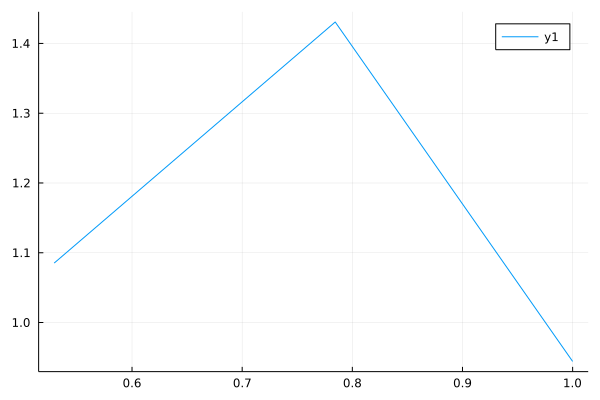

In [23]:
plot([(plot_pair[1], mean(plot_pair[2])) for plot_pair in plot_pairs])

In [ ]:
function get_fourier_meas_fn(m,n)
    true_m, meas_mat = sample_fourier(m, n)
    meas_mat = sqrt(n/true_m).*meas_mat
    return (meas_mat, x -> meas_mat*x)
end

In [ ]:
k = 1
mid = 1
n = 1
aimed_m = 1
num_signals = 2
meas_fn = get_fourier_meas_fn(aimed_m, n)[2]

β_array = [1.0]
plot_pairs = []
signal_errors = Array{Float64}(undef,num_signals)
#model, alignment = get_aligned_models(k, mid, n, [0,])[1]
model = get_rand_model(k,mid,n)
x₀ = randn(n)/sqrt(n)
measurements = meas_fn(x₀)

In [ ]:
measurements = meas_fn(x₀)
println(measurements)
x̂ = recover_signal(measurements, meas_fn, model, k)
println(meas_fn(x̂))
println(err,"   ", norm(x₀))

In [ ]:
model()

In [ ]:
k = 20
mid = 30
n = 100
aimed_m = 20
num_signals = 2
meas_fn = get_fourier_meas_fn(aimed_m, n)
β_array = 0:0.1:1
plot_pairs = []
signal_errors = Array{Float64}(undef,num_signals)
for (model, alignment) in get_aligned_models(k, mid,n, β_array)
    for i in 1:num_signals
        x₀ = randn(n)/sqrt(n)
        signal_error[i] = recovery_error(x₀, model, meas_fn, k)
    push!(plot_pairs, (alignment, mean(signal_errors)))
    end
end

In [ ]:
a = Array{Int}(undef,3)

In [ ]:
k = 20
n = 100
A = randn(n, k)
F = dct(diagm(ones(n)),2)
matrix_alignment(A, F)

In [ ]:
function plot_alignments()
    n= 500
    alignments = []
    normal_one = []
    F = dct(diagm(ones(n)),2)
    for k in 1:2:100
        A = randn(n, k)
        push!(alignments, matrix_alignment(A, F))
        push!(normal_one, sqrt(k/n))
    end
    plot(alignments)
    plot!(normal_one*0.9)
    xlabel!
    
end
plot_alignments()

In [ ]:
k = 20
n = 100
A = randn(n, k)
F = dct(diagm(ones(n)),2)
get_aligned_models

In [ ]:
for i in eachcol(A)
    println(i)
end

In [ ]:
F = dct(diagm(ones(n)),2)

In [ ]:
convert(Array,0:0.1:1.0)

In [ ]:
k = 20
mid = 100
n = 400
aimed_m = 23
num_meas, measure_mat = sample_fourier(aimed_m, n)
measure(x) = measure_mat*x
random_model = get_rand_model(k,mid,n)
#signal in range
true_signal = random_model(rand(Float64, k))
measurements = measure(true_signal);

In [ ]:
#@time recovered_signal = recover_signal(measurements, measure, random_model, k)
#println("The distance between signals is ", norm(recovered_signal - true_signal))
#println("The size of the true signal is ", norm(true_signal))

In [ ]:
function GD_CS(G, y, A, max_iter, stepsize, tolerance, out_toggle)
    _, k = size(Flux.params(G)[1])
    z = randn(k)
    iter = 1
    succ_error = 1
    d(z) = gradient(z -> norm(y - A*G(z))^2, z)[1]

    while iter <= max_iter && succ_error > tolerance
        # d gives the PLUGIn direction
        z -= stepsize * d(z)
        succ_error = norm(stepsize * d(z))
        if iter % out_toggle == 0  
            println("====> In Gradient: Iteration: $iter Successive error: $succ_error")
        end
        iter += 1
    end
    return z
end

In [ ]:
function get_aligned_model()

In the next experiment, we consider a one hidden layer network of the form $G(z) = A_2σ(A_1z)$. The inner layer matrix $A_1 \in \mathbb{R}^{n_1\times k}$ has $\mathcal{N}(0,1/n_1)$ entries. For the outer layer matrix $A_2 \in \mathbb{R}^{n_2\times n_1}$ ($n_2 = n$), we take a matrix $A_{21}$ which contains columns randomly subsampled (without replacement) from a $n\times n$ DCT matrix and a random matrix $A_{22}$ which contains $\mathcal{N}(0,1/n_2)$ entries and take its convex combination, i.e. 
$$A_2 = \beta A_{21} + (1-\beta) A_{22}$$
for $\beta \in [0,1]$.

For each $\beta \in [0.7,1]$, we attempt to recover the code vector $z_0$ from measurement of the form $y = A G(z_0)$ where $A \in \mathbb{R}^{m\times n}$ is subsampled DCT matrix (without replacement) by solve the least squares optimzation problem using the gradient descent algorithm. We show the results from 20 trials for each $\beta$ and for all trials, $z_0, A_1, A_{21}$, and $A_{22}$ are fixed. For all experiments, $k = 20, n = 400$, $n_1$ is approximately 100, and $m$ is approximately 160.

In [ ]:
#setup a synthetic problem
x_dim = 400
k = 20

# F = real(fft(diagm(ones(x_dim)),2))
F = dct(diagm(ones(x_dim)),2)

# sampling rows of DCT matrix for outer layer
sampling = rand(Bernoulli(100/x_dim), x_dim)
sampling = convert.(Int, sampling)
ndm1 = sum(sampling) #number of neurons n_1
nnzindex = []
for i in 1:length(sampling)
    if sampling[i] != 0
        push!(nnzindex, i)
    end
end

A = F[nnzindex,:]' # subsampled DCT
B = randn(x_dim, ndm1)/sqrt(x_dim) #random matrix thats used in convex combination

W1 = randn(ndm1, 20)/sqrt(ndm1) #random inner layer weight matrix

I(x) = x
z = randn(k) # ground code vector

β_list = .7:.01:1
trials = 20
recovery_error_matrix = zeros(length(β_list))
recon_error_matrix = zeros(length(β_list))
α_list = []

for trial in 1:trials
    recovery_error_list = []
    recon_error_list = []   
    α_list = []
    for β in β_list
        Aint = β*A + (1-β) * B

        #setup the generative network 
        G = Chain(
            Dense(20, ndm1, relu, bias = false; init =(out,in) -> W1),
            Dense(ndm1, x_dim, I, bias = false; init =(out,in) -> Aint)
        )

        # subsampling DCT for measurement matrix
        sampling = rand(Bernoulli(.4), x_dim)
        sampling = convert.(Int, sampling)
        m = sum(sampling)
        nnzindex = []
        for i in 1:length(sampling)
            if sampling[i] != 0
                push!(nnzindex, i)
            end
        end
        F_sub = F[nnzindex,:]*sqrt(x_dim)/sqrt(m)

        # measurement vector using subsampled DCT matrix
        y = F_sub*G(z)

        stepsize = .5
        tolerance = 1e-14
        max_iter = 2000
        out_toggle = 2001

        # run gradient descent to solve the least squares problem
        z_rec = GD_CS(G,y,F_sub, max_iter, stepsize, tolerance, out_toggle)
        recov_error = norm(z - real(z_rec))/norm(z)
        recon_error = norm(G(z) - G(real(z_rec)))/norm(G(z))
        Fn = F  
        α = maximum(sum((Fn*Aint)' .* (Fn*Aint)', dims = 1) ./ sqrt.(sum((Fn*Aint*Aint')' .* (Fn*Aint*Aint')', dims = 1)))

        # save results
        push!(recovery_error_list, recov_error)
        push!(recon_error_list, recon_error)
        push!(α_list, α)

    end
    #save results
    recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
    recon_error_matrix = hcat(recon_error_matrix, recon_error_list)


end
